# My Network Summary


In [ ]:
# !pip install matplotlib networkx numpy pandas seaborn scipy scikit-learn python-louvain

In [144]:
import math
from collections import Counter

import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from networkx.algorithms import community as com
from scipy import stats
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.stats import linregress, spearmanr
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
G = nx.read_gexf("./alinas_graph.gexf")

## Graph description

The graph was generated using the script `data_collection.py`. It represents my friend network on VKontakte (VK). The graph has the following properties:  

- **Undirected**: Connections between nodes (friends) are mutual, without a defined direction.  
- **Unweighted**: All edges have equal weight, meaning no additional significance is assigned to connections.  
- **Homogeneous**: All nodes represent the same type of entity—users in the social network—and all edges represent the same type of relationship—friendship.  


The brief description of the node attributes:

- **name**: The full name of the person.  
- **name_label**: A formatted version of the name, possibly for display purposes.  
- **sex**: The gender of the person ('м' for male, 'ж' for female).  
- **byear**: The birth year of the person.  
- **city**: The city where the person resides.  
- **country**: The country where the person resides.  
- **faculty_name**: The name of the faculty the person is associated with.  
- **university_name**: The name of the university the person is associated with.  
- **n_friends**: The number of friends the person has in the social network.  
- **label**: A display label for the person, usually their name.  
- **size**: A numerical value representing the size of the node in a graph.

In [4]:
set([k for n in G.nodes for k in G.nodes[n].keys()])

{'byear',
 'city',
 'country',
 'faculty_name',
 'label',
 'n_friends',
 'name',
 'name_label',
 'sex',
 'size',
 'university_name'}

Example of a person as a node:

In [21]:
G.nodes['3115302']

{'name': 'Галина Крынецкая',
 'name_label': 'Галина\nКрынецкая',
 'sex': 'ж',
 'byear': '1973',
 'city': 'Москва',
 'country': '',
 'faculty_name': 'Кибернетики (К)',
 'university_name': 'НИЯУ МИФИ',
 'n_friends': 1130,
 'label': 'Галина Крынецкая',
 'size': 10}

The field descriptions of edge attributes:  

1. **mut_friends** – the number of mutual friends between two nodes (users) in the social network.  
2. **id** – a unique identifier for the edge, used to distinguish connections from one another.  
3. **width** – a numeric value representing the "weight" of the connection (always 1).  

In [5]:
set([k for n in G.edges for k in G.edges[n].keys()])

{'id', 'mut_friends', 'width'}

In [26]:
G.edges[('87215', '4782485')]

{'mut_friends': 37, 'id': '1', 'width': 1}

## Numerical properties of the graph

In [27]:
print('The number of edges:', G.size())
print('The number of nodes:', G.order())

The number of edges: 2427
The number of nodes: 281


Diameter and radius of maximum connected component

In [28]:
g = max(nx.connected_components(G), key=len) 
g = G.subgraph(g).copy() 

Definition for those who don't know:

1) **The diameter of a graph** is the longest shortest path between any two nodes. In this case, the longest shortest path is 8.
 
2) **The radius of a graph** is the minimum eccentricity of any node. Eccentricity is the longest shortest path from a node to any other node.

In [29]:
print('Diameter:', nx.diameter(g))
print('Radius:', nx.radius(g))

Diameter: 8
Radius: 4


My small observation:

1) The relatively large diameter (8) compared to the radius (4) indicate that the graph is not densely connected but still has certain central nodes or hubs that reduce the effective distance for most nodes.

2) A diameter of 8 is not uncommon for social networks, as they often exhibit the small-world property where most nodes are connected through relatively few intermediaries.

This is the visualization of my graph :)
You also can see it in the file `network_visualization.html`

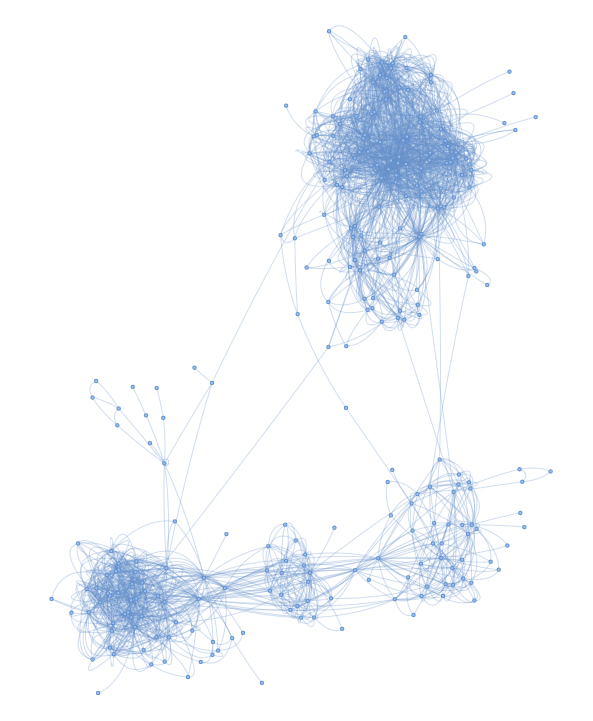

## Clustering Coefficient 
*   global
*   average local
* histogram of locals



In [32]:
print('Average clustering:', nx.average_clustering(G))

Average clustering: 0.5210777587129578


On average, 52.1% of the possible triangles around a node are actually present.

In [33]:
global_clustering = nx.transitivity(G)
print('Global clustering:', global_clustering)

Global clustering: 0.5237144487001875


About 52.37% of all connected triplets in the graph are closed into triangles.

The graph has a moderate level of clustering at the local node level. This is typical on social networks, where friends of friends are often friends too (so it looks correct).

In [34]:
def color_seq(dict_to_sort):
  """
  Sorts dict by values and returns sequense to use in graph as node colors
  """
  sorted_d = sorted(dict_to_sort, key=dict_to_sort.get)
  return [sorted_d.index(el) for el in dict_to_sort.keys()]

In [35]:
def best_names_labels(values_dict, n, graph, rev=False):
  """
  Returns dict of top names to write them on nodes on graph
  """
  best_names = {}
  sorted_val = sorted(values_dict, key=values_dict.get, reverse=rev)
  for n in sorted_val[:n]:
    best_names.update({n: graph.nodes[n]['name']})

  return best_names

In [36]:
def draw_color_graph(dict_val, graph, fig, col_bar_lab, ax_n=None, 
                     node_colors=False, spec_labels=False, rev=False):
  """
  Draw graph with kamada kawai layoyt and known color dictribution
  """
  if spec_labels:
    if rev:
      s_labels = best_names_labels(dict_val, 5, g, True)
    else:
      s_labels = best_names_labels(dict_val, 5, g)
  else:
    s_labels = {}

  if node_colors:
    n_colors = color_seq(dict_val)
  else:
    n_colors = range(len(graph.nodes()))

  nx.draw_kamada_kawai(graph, 
                       ax=ax_n,
                       node_color=n_colors,
                       cmap=plt.cm.RdPu,
                       labels=s_labels, 
                       font_size=10,
                       node_size=80, 
                       width=0.2)
  norm = plt.Normalize(0, max(dict_val.values()))

  fig.colorbar(ScalarMappable(cmap='RdPu', norm=norm), 
             ax=ax_n,
             label=col_bar_lab)

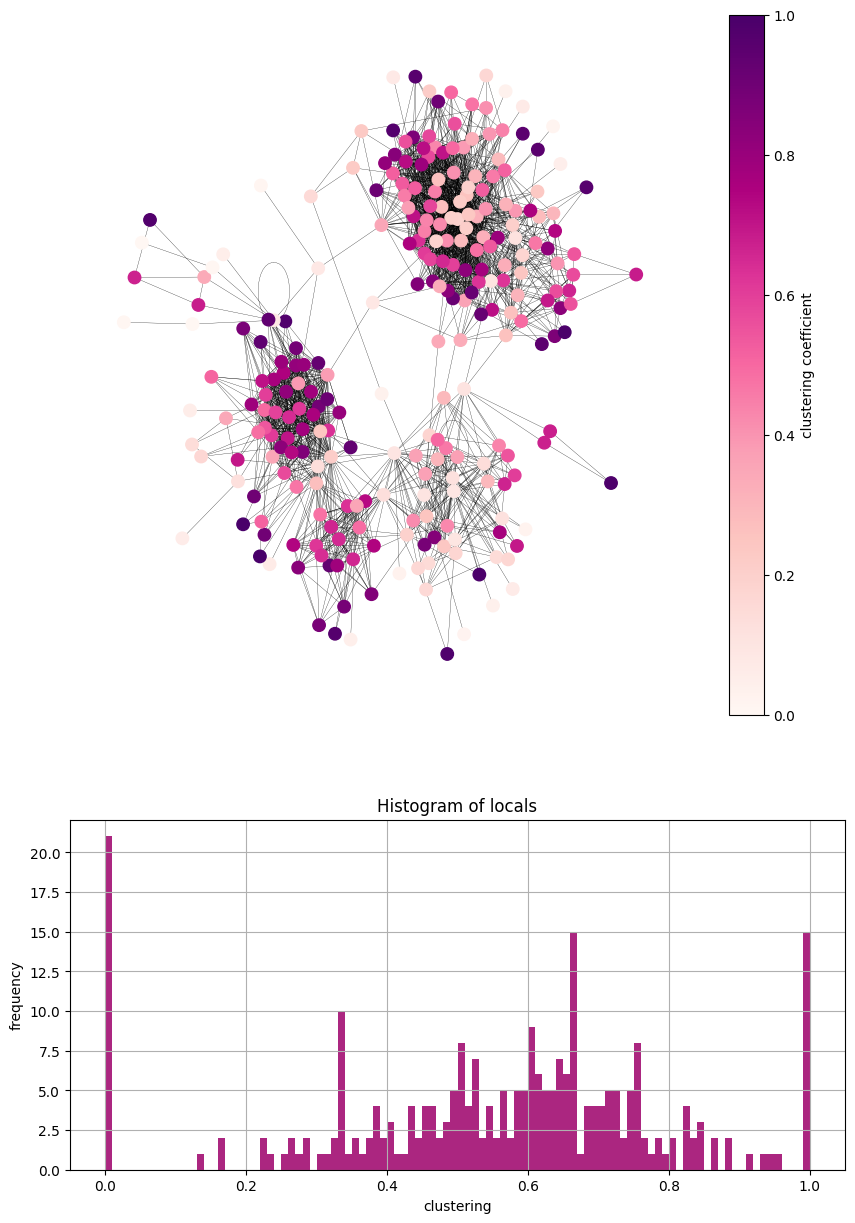

In [37]:
cluster_coef = nx.clustering(g)

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10,15))

draw_color_graph(cluster_coef, g, fig, 'clustering coefficient', ax0,
                 node_colors=True, rev=False)

ax1.hist(cluster_coef.values(), bins=100, color=[0.67, 0.15, 0.5, 1])
ax1.set_title('Histogram of locals')
ax1.set_xlabel('clustering')
ax1.set_ylabel('frequency')
ax1.grid()

plt.show()

There is a significant number of nodes with a clustering coefficient of 0, indicating sparse or no connections among their neighbours. The histogram peaks around 0.6, suggesting that most nodes have a moderately high level of local clustering. Some nodes have a maximum clustering coefficient of 1, meaning all their neighbours are interconnected.  

**Conclusions:**  
The graph exhibits distinct clusters (communities) that are well-connected internally, with sparser connections between different clusters. The clustering distribution reflects nodes with varying levels of involvement in local communities, from isolated to fully integrated.

## Average path length

In [38]:
print('Average shortest path length:', nx.average_shortest_path_length(g))

Average shortest path length: 3.441209764026355


In [39]:
avg_path_lengths = dict([(node, np.mean(list(lengths.values()))) for node, lengths in dict(nx.all_pairs_shortest_path_length(g)).items()])

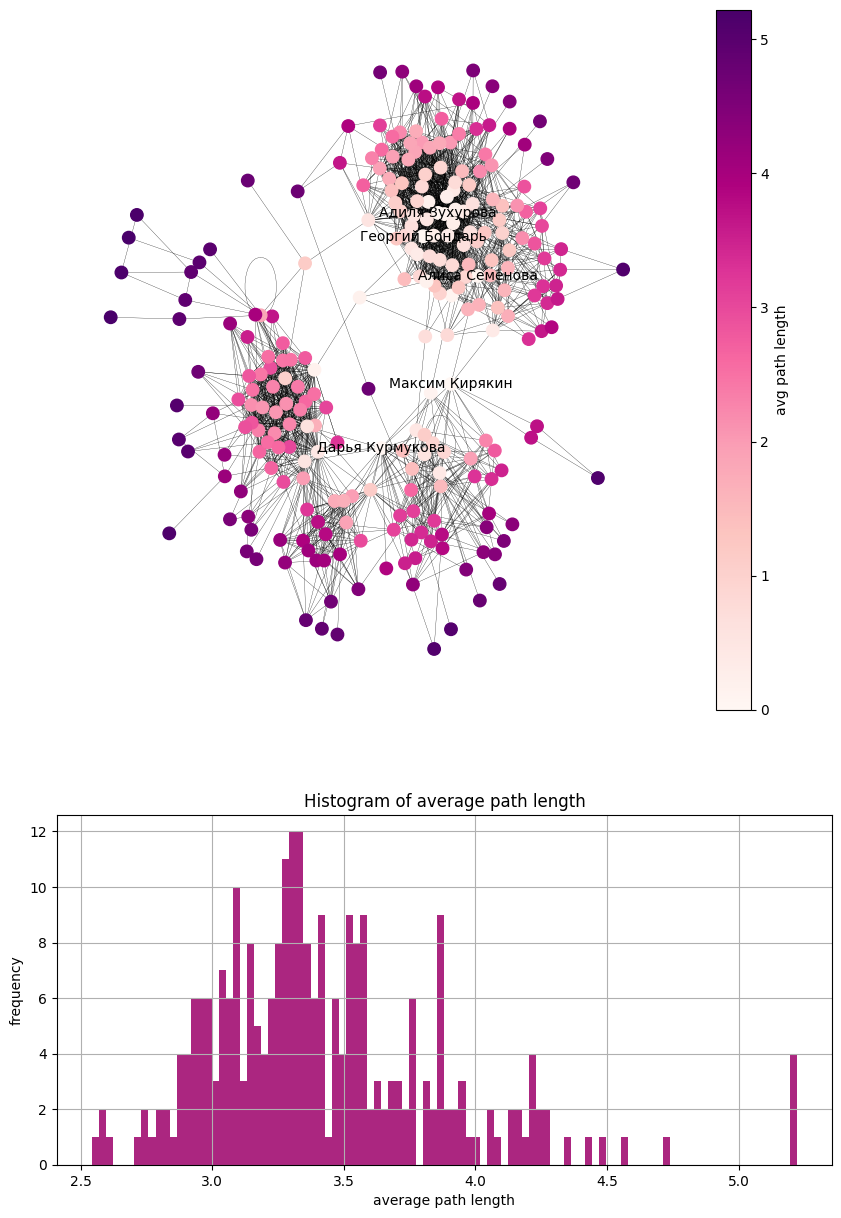

In [40]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10,15))

draw_color_graph(avg_path_lengths, g, fig, 'avg path length',ax0, 
                 node_colors=True, 
                 spec_labels=True, rev=False)

ax1.hist(avg_path_lengths.values(), bins=100, color=[0.67, 0.15, 0.5, 1])
ax1.set_title('Histogram of average path length')
ax1.set_xlabel('average path length')
ax1.set_ylabel('frequency')
ax1.grid()

plt.show()

The network is visually divided into clusters. The graph labels indicate names that represent central nodes (leaders or key figures) within their clusters or connections.

Most nodes have an average path length ranging from 3.0 to 4.0. The distribution is slightly asymmetric, with a small number of nodes having an average path length exceeding 4.5.  

This further supports the conclusion that the network has a distinct cluster structure.

## Degree distribution

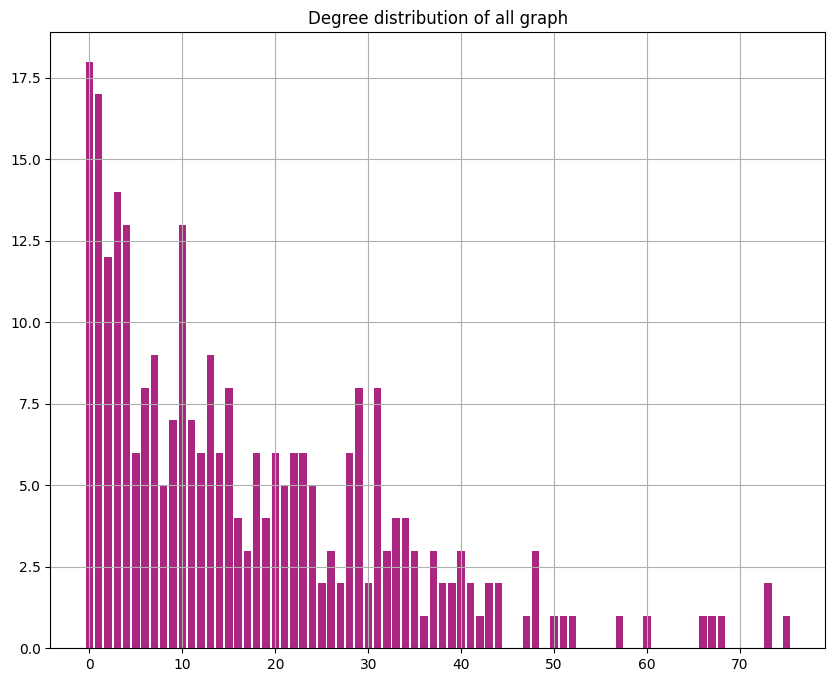

In [24]:
plt.figure(figsize=(10, 8))
degree_seq = [degree for (node, degree) in G.degree]
bins, freq = np.unique(degree_seq, return_counts=True)
plt.bar(bins, freq, color=[0.67, 0.15, 0.5, 1])
plt.title('Degree distribution of all graph')
plt.grid()
plt.show()

Observations:

1) The distribution has a clear right tail: most nodes have a low degree, while a small number of nodes have a high degree (which makes sense for a graph of my friends).

2) The highest frequency is observed for nodes with degrees ranging from 1 to 10, indicating that most nodes in the graph have relatively few connections.

3) There are nodes with degrees exceeding 50, reaching up to 70 or more—these are the hubs, my most sociable friends :) As seen, there aren't many of them.


In [44]:
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top-5 nodes by degree centrality:")
for node, centrality in sorted_degree_centrality[:5]:
    print(f"Node: {g.nodes[node]['name']}, Degree centrality: {centrality:.4f}")

betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop-5 nodes by betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:5]:
    print(f"Node: {g.nodes[node]['name']}, Betweenness centrality: {centrality:.4f}")

Top-5 nodes by degree centrality:
Node: Галина Крынецкая, Degree centrality: 0.2679
Node: Алиса Семенова, Degree centrality: 0.2607
Node: Георгий Бондарь, Degree centrality: 0.2607
Node: Даниил Волков, Degree centrality: 0.2429
Node: Арсений Иванов, Degree centrality: 0.2393

Top-5 nodes by betweenness centrality:
Node: Алиса Семенова, Betweenness centrality: 0.1557
Node: Максим Кирякин, Betweenness centrality: 0.1463
Node: Дарья Курмукова, Betweenness centrality: 0.1406
Node: Николай Гусаров, Betweenness centrality: 0.1380
Node: Алексей Соломатин, Betweenness centrality: 0.1352


**High degree centrality:**  
The node has many connections with other nodes. Such a node can be influential or central in the cluster, since it interacts with a large number of other network participants.  
For example:  
- Galina Krynetska - my curator at University.
- Alisa Semeonova - my friend, who organized sportprogramming club at University.  

**High betweenness centrality:**  
The node is a bridge between clusters or other nodes. Removing such a node can significantly disrupt the connection in the graph.  
For example:  
- Maxim Kirakin - my friend, who is my ex-classmate at school and he also know some students from my university, including Alisa Semeonova, who has many connections in the graph.



Power law check:
Slope (exponent): -0.7524, R^2: 0.6866


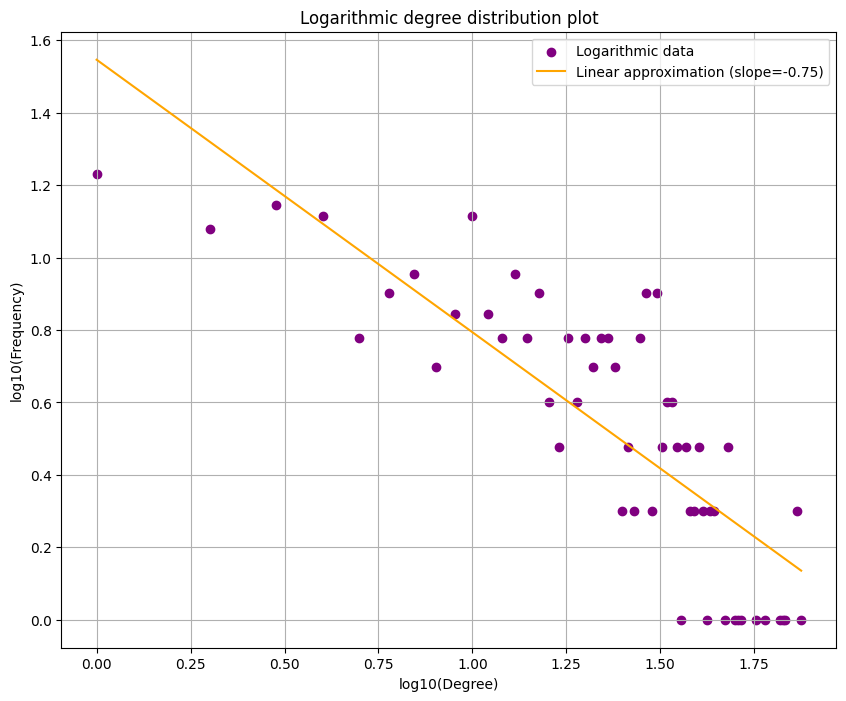

In [45]:
degree_seq = [degree for (node, degree) in G.degree]
bins, freq = np.unique(degree_seq, return_counts=True)

log_bins = np.log10(bins[bins > 0])
log_freq = np.log10(freq[bins > 0])

slope, intercept, r_value, p_value, std_err = linregress(log_bins, log_freq)
print(f"\nPower law check:")
print(f"Slope (exponent): {slope:.4f}, R^2: {r_value**2:.4f}")

plt.figure(figsize=(10, 8))
plt.scatter(log_bins, log_freq, color='purple', label='Logarithmic data')
plt.plot(log_bins, slope * log_bins + intercept, color='orange', label=f"Linear approximation (slope={slope:.2f})")
plt.title("Logarithmic degree distribution plot")
plt.xlabel("log10(Degree)")
plt.ylabel("log10(Frequency)")
plt.grid()
plt.legend()
plt.show()


Negative value (-0.7524) indicates that the frequency of nodes with a higher degree decreases according to the power law, but quite smoothly. In classical scale-free networks (scale-free networks) the slope is usually in the range from -2 to -3. This indicates that this is only my friends' graph, not the entire VK. 

Coefficient of determination shows how well the logarithmic regression explains the data. The value of 1.0 means perfect fit. In this case, R² = 0.6866, which indicates a moderate degree of fit to the power law.

The data does not perfectly follow the power law, but there is a general trend to follow it (this happened becouse of clusters).


## PDF, CDF

In [46]:
pdf = [prob/g.number_of_nodes() for prob in nx.degree_histogram(g)]
cdf = np.cumsum([prob/g.number_of_nodes() for prob in nx.degree_histogram(g)])

In [47]:
def visualize_cdf_pdf(distr_func, title):
  plt.figure(figsize=(10,6)) 
  plt.plot(distr_func, color=[0.67, 0.15, 0.5, 1])
  plt.ylabel('probability')
  plt.xlabel('node degrees')
  plt.title(title)
  plt.xticks(np.arange(0, 50, 5))
  plt.show()

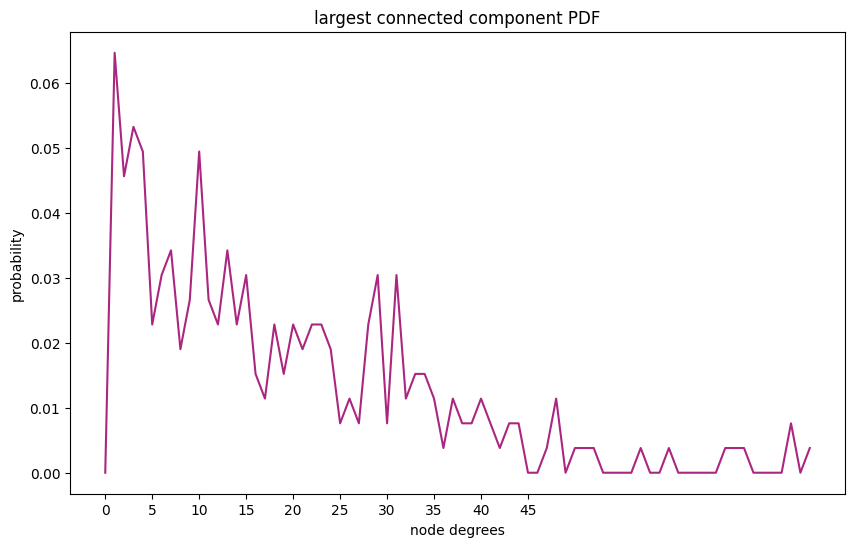

In [48]:
visualize_cdf_pdf(pdf, 'largest connected component PDF')

Most nodes in the graph have a small number of connections. These are nodes on the periphery or less active participants in the network.

Nodes with high degree (hubs) exist, but their probability is extremely low.

From the graph we can see that the graph has a clustered structure with several hubs that connect separate groups of nodes.

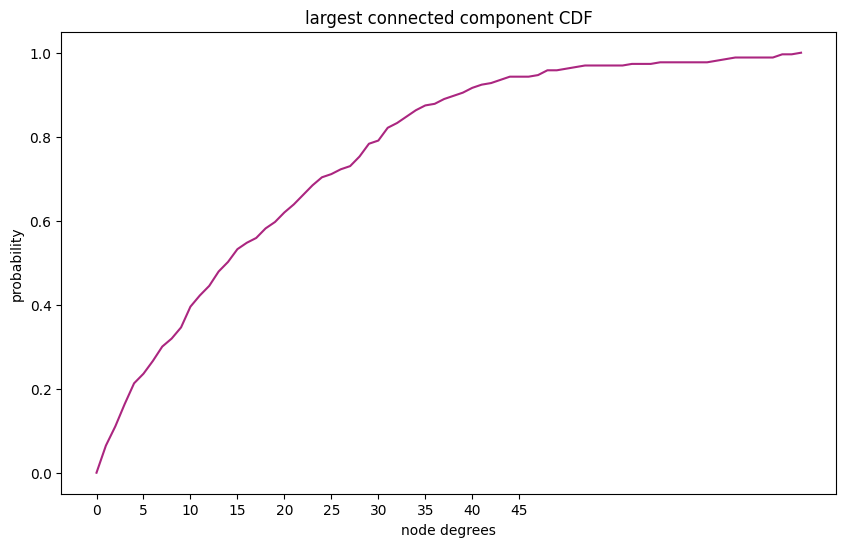

In [49]:
visualize_cdf_pdf(cdf, 'largest connected component CDF')

The graph has properties typical of real networks: most nodes with a small degree, supplemented by a small number of key nodes with a high degree, which makes the graph robust to random damage, but vulnerable to the removal of hubs


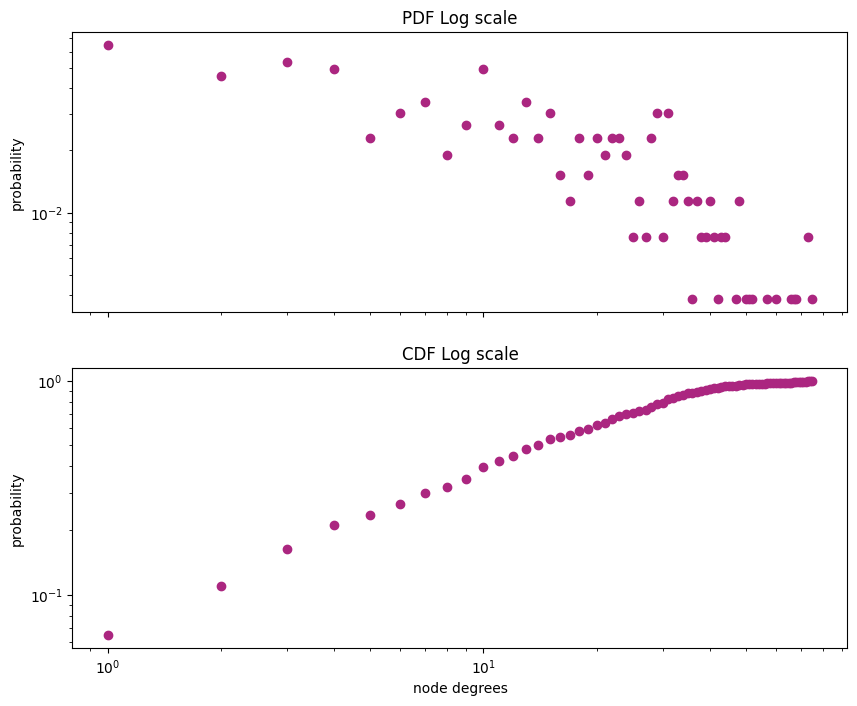

In [50]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,8))
ax1.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color=[0.67, 0.15, 0.5, 1],
           marker='o',
           linestyle='None')
ax1.set_ylabel('probability')
ax1.set_title('PDF Log scale')
        
ax2.loglog(np.arange(0, len(cdf)), 
           cdf, 
           color=[0.67, 0.15, 0.5, 1], 
           marker='o', 
           linestyle='None')
ax2.set_ylabel('probability')
ax2.set_xlabel('node degrees')
ax2.set_title('CDF Log scale')
plt.show()

Observations:
1) **Scale-free structure:** The graph exhibits a scale-free or power-law-like degree distribution, where most nodes have few connections, and a small number of nodes act as highly connected hubs.
2) **Clustered community structure:** The presence of hubs and a steep drop in the PDF is consistent with networks that have tightly-knit communities connected by key influential nodes.
3) **Social network characteristics:** This pattern aligns with typical social networks where most people (nodes) have a limited number of friends, but a few individuals (hubs) have significantly more connections.

## Fitting PDF

In [51]:
'''
MLE
'''
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * 1/(-alpha + 1) * x ** (-alpha + 1)

def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def mle_power_law_params(degree_sequence):

  x_max = int(degree_sequence.max())
  x_min = int(degree_sequence.min())
  result_list = []

  while x_min < x_max:
    cutted_degree_sequence = degree_sequence[degree_sequence >= x_min]
    alpha = 1 + cutted_degree_sequence.size * 1/np.sum(np.log(cutted_degree_sequence / x_min))
    kstest = stats.kstest(cutted_degree_sequence, 
                                cdf = lambda x: power_law_cdf(x, alpha, x_min))
    result_list.append((alpha, x_min, kstest[0]))
    x_min += 1
    
  return min(result_list, key = lambda t: t[2])[:2]

In [53]:
'''
Linear Regression
'''
def alpha_log_bins(x_train, bins):
  binning = np.logspace(np.log10(x_train.min()), np.log10(x_train.max()), bins)
  histogram = np.histogram(x_train, bins=binning, density=True)
  density = histogram[0][np.where(histogram[0] != 0)]
  density = np.log(density / len(x_train))
  bin_centres = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
  bin_centres = bin_centres[np.where(histogram[0] != 0)]
  bin_centres = bin_centres.reshape(-1, 1)
  regression = LinearRegression()
  regression.fit(bin_centres, density)
  
  return abs(regression.coef_[-1])

<Figure size 1500x1000 with 0 Axes>

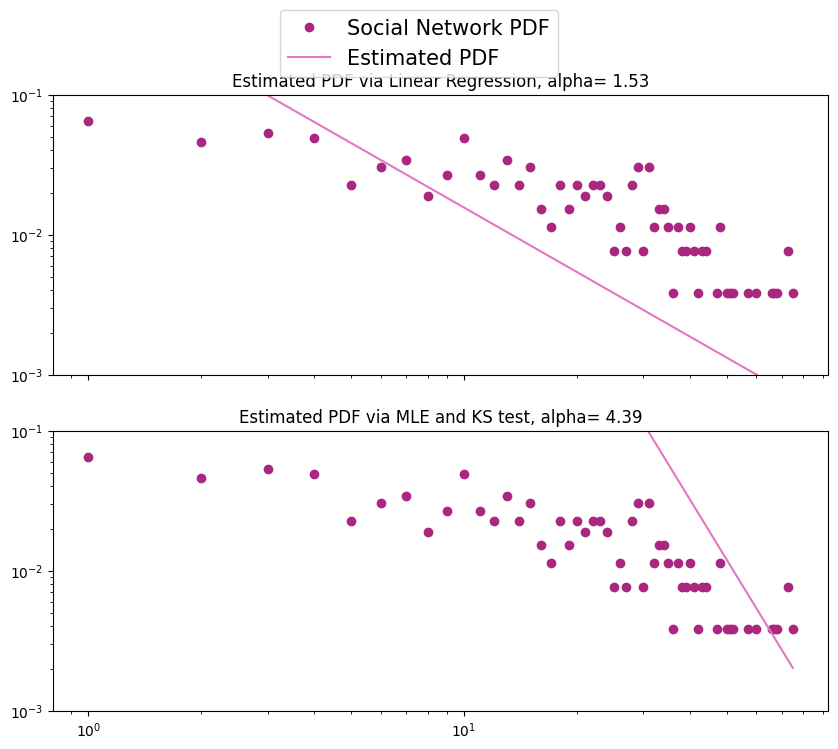

In [54]:
bins = 100
degree_sequence = np.array(list(dict(nx.degree(g)).values()))
x_min = degree_sequence.min()

binning = np.logspace(np.log10(x_min), np.log10(degree_sequence.max()), bins)
hist, bin_edges = np.histogram(degree_sequence, bins=binning, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
x_space = np.linspace(x_min, degree_sequence.max(), 100)


plt.figure(figsize=(15,10))   
plt.rcParams['axes.grid'] = False
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,8))


ax1.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color=[0.67, 0.15, 0.5, 1], 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha_reg = alpha_log_bins(degree_sequence, bins)
ax1.loglog(x_space, power_law_pdf(x_space, hat_alpha_reg, x_min), 
         label='Estimated PDF', c='tab:pink')
ax1.set_title('Estimated PDF via Linear Regression, alpha= {:.2f}'.format(hat_alpha_reg))
ax1.set_ylim(0.001, 0.1)
        
ax2.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color=[0.67, 0.15, 0.5, 1], 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
ax2.loglog(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:pink')
ax2.set_title('Estimated PDF via MLE and KS test, alpha= {:.2f}'.format(hat_alpha))
ax2.set_ylim(0.001, 0.1)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', prop={'size': 15})

plt.show()

**Linear regression vs MLE**:
   - The **top plot** estimates the power-law exponent $\alpha$ = 1.53 via linear regression. This value suggests a flatter distribution with more high-degree nodes.
   - The **bottom plot** uses MLE and the KS test, resulting in a steeper exponent $\alpha$ = 4.39, indicating fewer high-degree nodes compared to linear regression.

## Some network information

In [70]:
g = max(nx.connected_components(G), key=len) 
g = G.subgraph(g).copy() 

In [38]:
G.nodes['87215'].keys()

dict_keys(['name', 'name_label', 'sex', 'byear', 'city', 'country', 'faculty_name', 'university_name', 'n_friends', 'label', 'size'])

As already shown, nodes in the grapn have some attributes: 
* 'byear' - year of birth
* 'city',
* 'country',
* 'faculty_name',
* 'n_friends' - number of friends  
* 'sex'
* 'university_name'

And edges have attribute 'mut_friends' - number of mutual friend between 2 people

Let's look what we can find out from this information


Statistics for attribute sex:
м: 136
ж: 126


/tmp/ipykernel_78228/3489724513.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


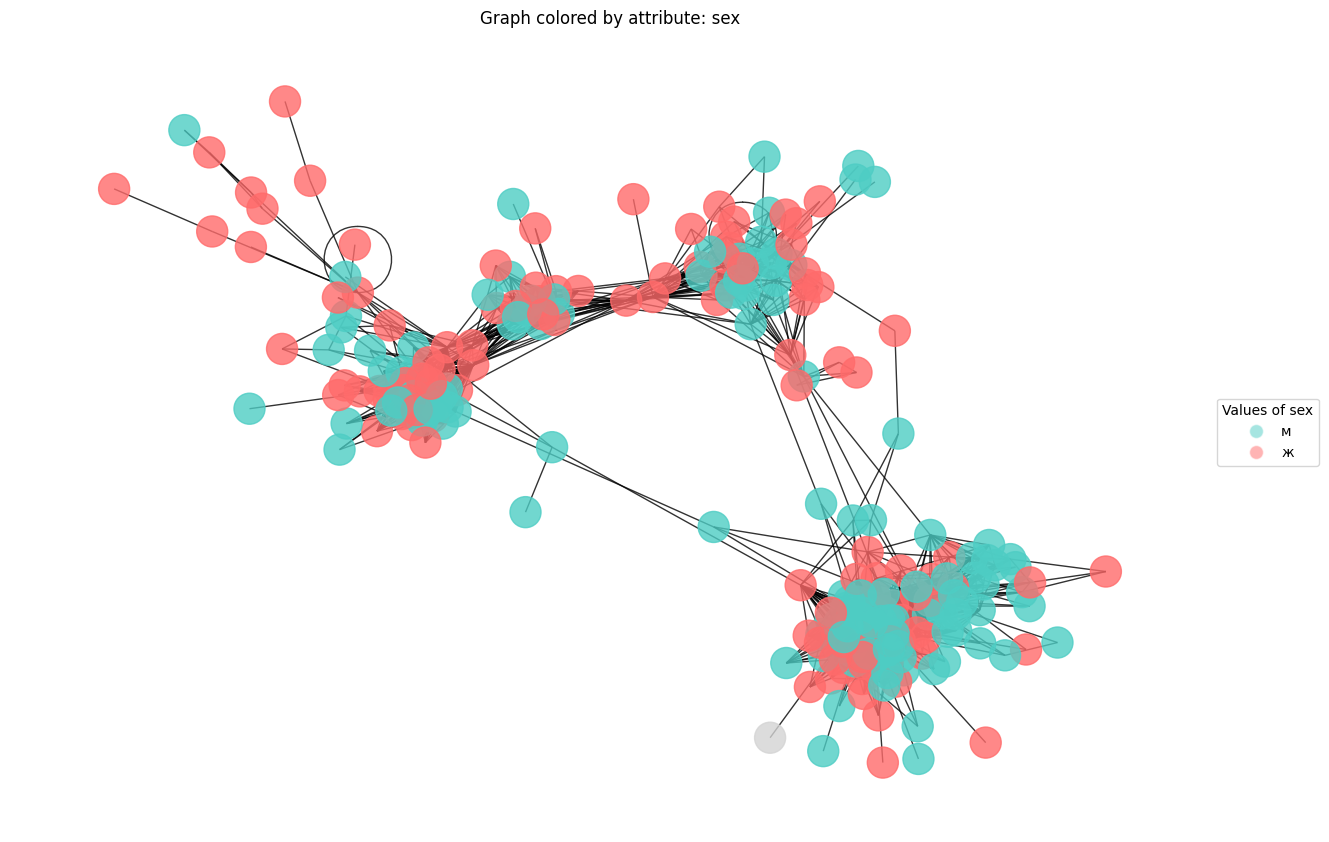


Statistics for attribute byear:
: 153
Others: 106
1906: 1
1905: 1
1917: 1


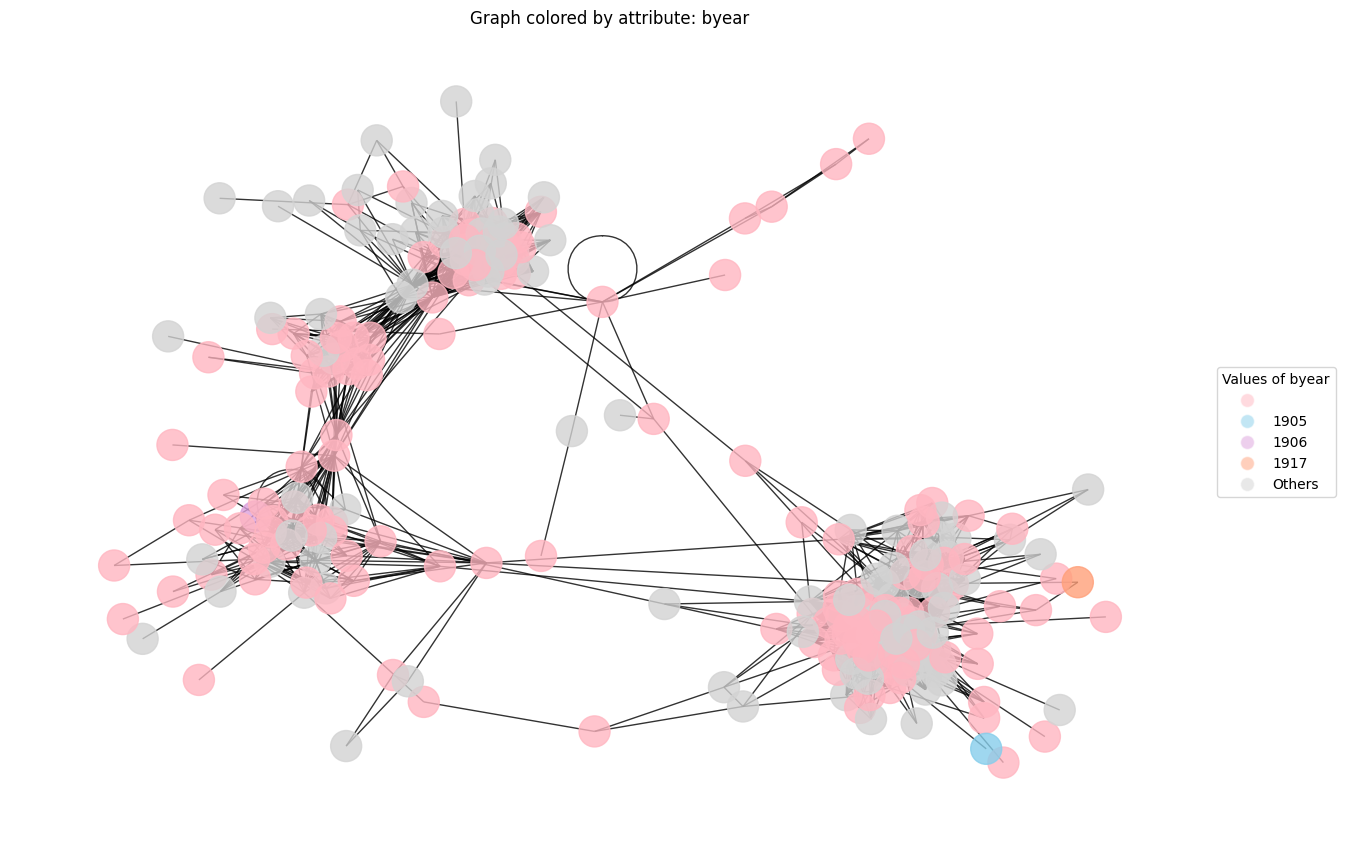


Statistics for attribute city:
Others: 190
: 69
Porto: 1
Centralia: 1
Bakau: 1


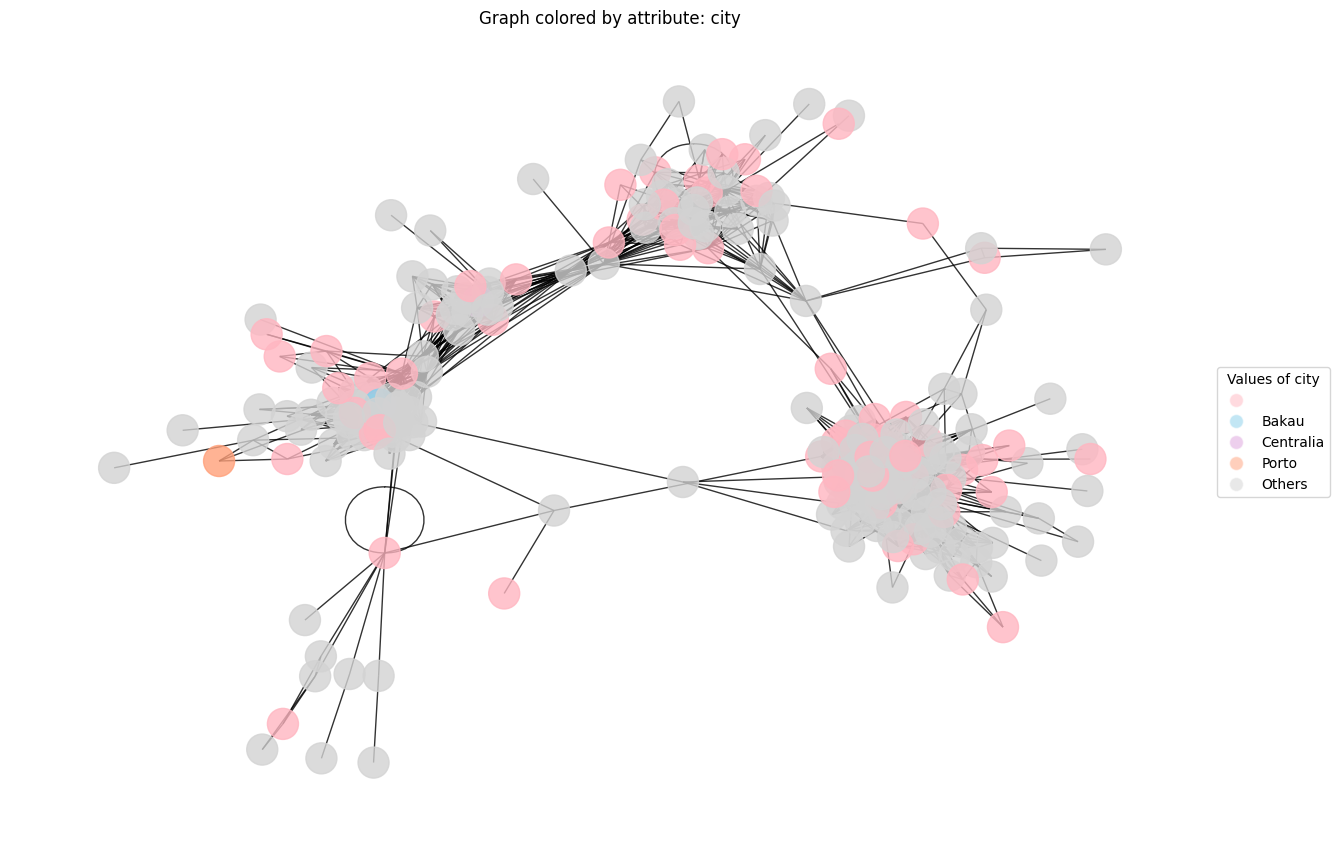


Statistics for attribute country:
: 262


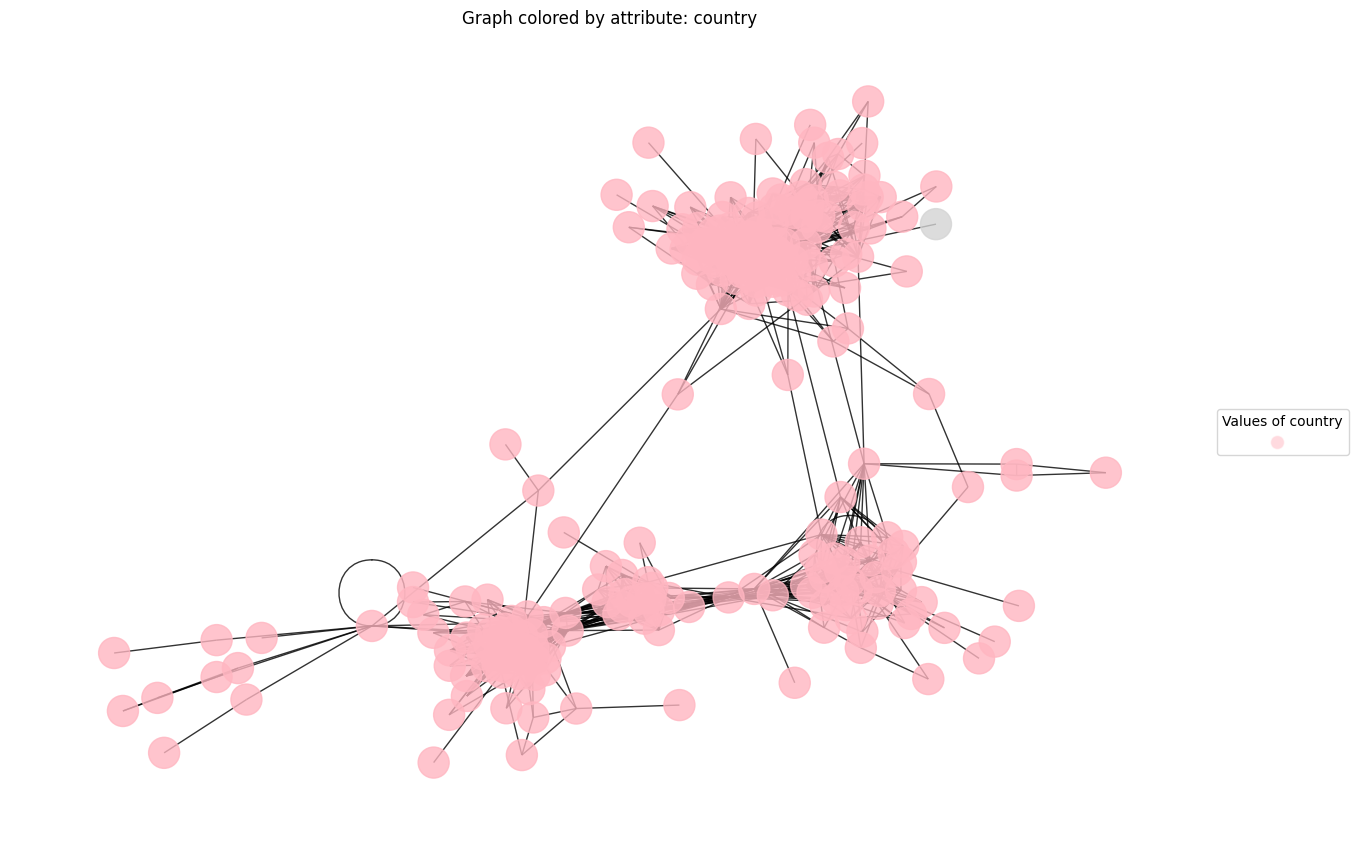


Statistics for attribute faculty_name:
: 158
Others: 101
Дефектологический факультет (Институт детства): 1
Британская высшая школа дизайна (University of Hertfordshire): 1
Геологоразведочный факультет: 1


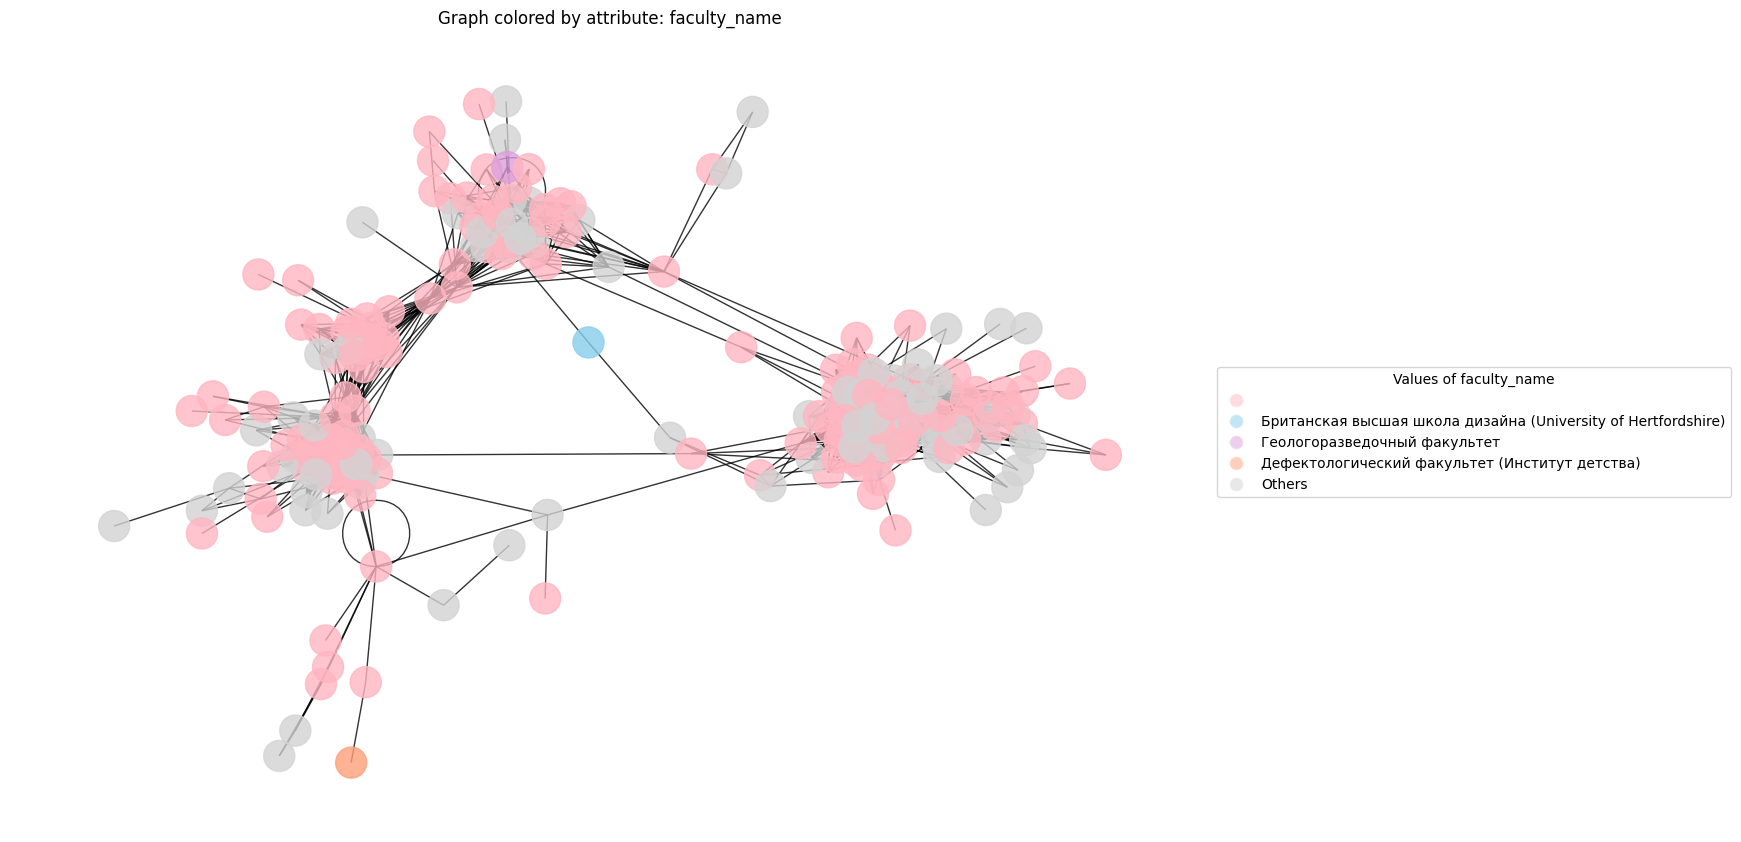


Statistics for attribute university_name:
Others: 136
: 123
АГУ
: 1
ГИТИС: 1
Дипломатическая академия МИД РФ: 1


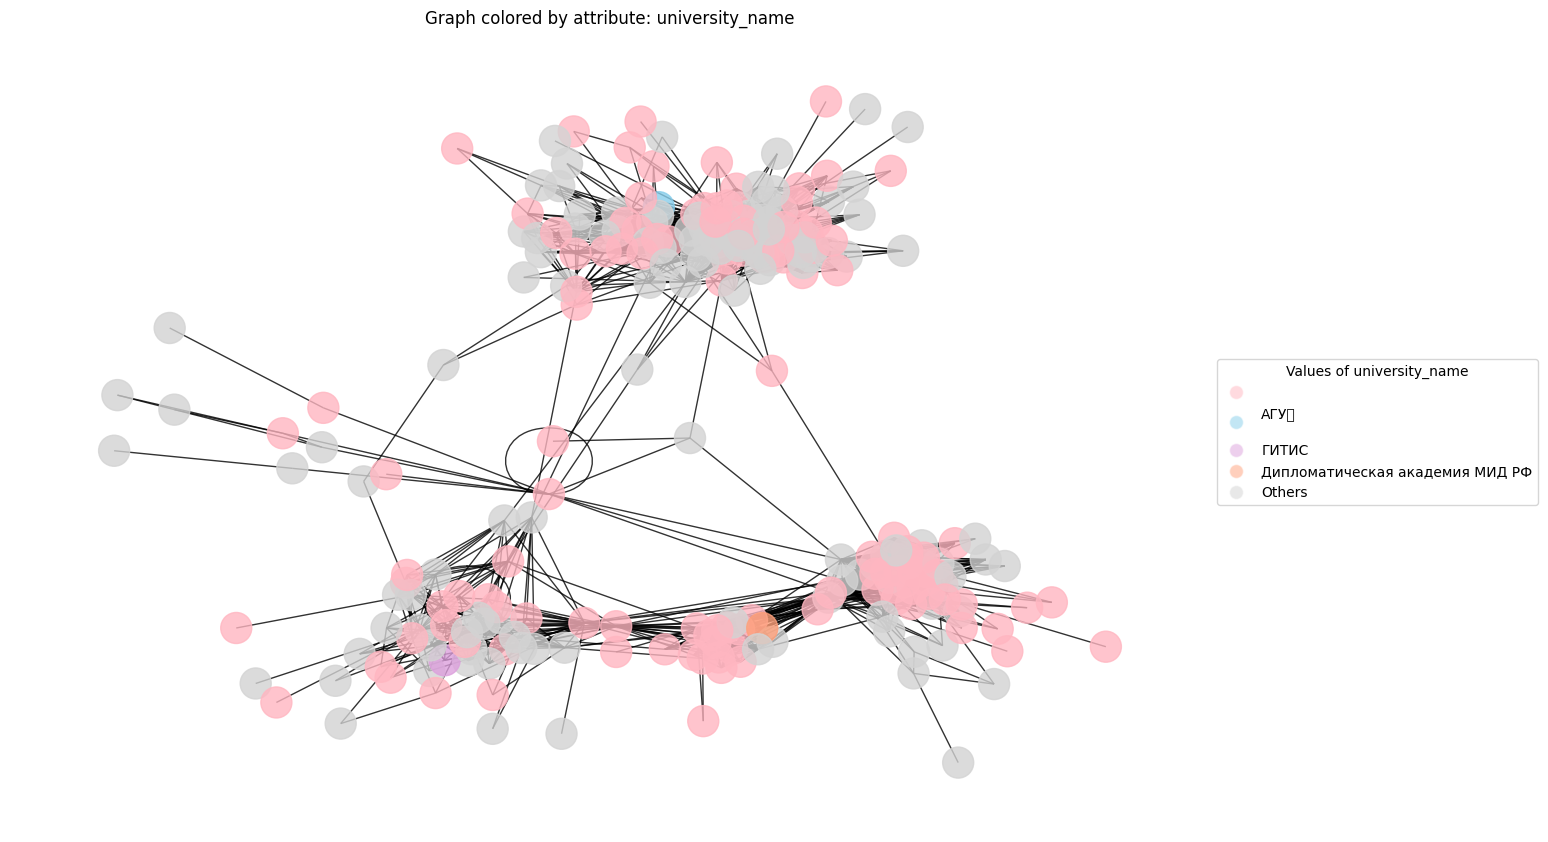

In [71]:
def visualize_graph_by_attribute(g, attribute, figsize=(12, 8)):
    values = set()
    for node in g.nodes():
        if attribute in g.nodes[node]:
            values.add(g.nodes[node][attribute])
    values = sorted(list(values))
    
    if len(values) > 4:
        top_values = values[:4]
        values = top_values + ['Others']
    
    colors = ['#FFB6C180', '#87CEEB80', '#DDA0DD80', '#FFA07A80', '#D3D3D380']
    color_map = dict(zip(values, colors))
    
    if attribute == 'sex':
        color_map = {'м': '#4ECDC480', 'ж': '#FF6B6B80'}
    
    def get_color(node):
        if attribute not in g.nodes[node]:
            return '#D4D4D480'
        value = g.nodes[node][attribute]
        if len(values) > 4 and value not in values[:4]:
            return color_map['Others']
        return color_map.get(value, '#D4D4D480')
    
    node_colors = [get_color(node) for node in g.nodes()]
    
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(g)
    nx.draw(g, pos, node_color=node_colors, with_labels=False, node_size=500, alpha=0.8)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=color, label=value, markersize=10)
                      for value, color in color_map.items()]
    plt.legend(handles=legend_elements, title=f'Values of {attribute}',
               loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title(f'Graph colored by attribute: {attribute}')
    
    value_counts = {}
    for node in g.nodes():
        if attribute in g.nodes[node]:
            value = g.nodes[node][attribute]
            if len(values) > 4 and value not in values[:4]:
                value = 'Others'
            value_counts[value] = value_counts.get(value, 0) + 1
    
    print(f"\nStatistics for attribute {attribute}:")
    for value, count in sorted(value_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{value}: {count}")
        
    plt.tight_layout()
    plt.show()

attributes = ['sex', 'byear', 'city', 'country', 'faculty_name', 'university_name']
for attr in attributes:
    visualize_graph_by_attribute(g, attr)

# Structural Analysis

## Comparison with random graphs 

In [75]:
g = max(nx.connected_components(G), key=len) 
g = G.subgraph(g).copy() 

In [76]:
n_nodes = len(g.nodes())
avg_edges = int(np.array([d for n, d in g.degree()]).mean())
prob = avg_edges/n_nodes

Generating Erdos Renyi, Barabasi Albert and Watts-Strogatz random graphs

In [77]:
def graph_properties(g):
  diameter = nx.diameter(g)
  radius = nx.radius(g)
  avg_path = nx.average_shortest_path_length(g)
  clustering = nx.average_clustering(g)
  return {'diameter': diameter,
          'radius': radius,
          'avg shortest path': avg_path,
          'avg clustering': clustering}

def get_gk(expected, actual, sigma): 
  return {k: (math.exp(-(expected[k]-actual[k])**2/(2*sigma[k]**2))) for k in actual}

In [78]:
er = nx.fast_gnp_random_graph(n_nodes, prob, seed=1)
ba = nx.barabasi_albert_graph(n_nodes, avg_edges, seed=1)
ws = nx.watts_strogatz_graph(n_nodes, avg_edges, p=0.1, seed=1)

graphs_list = [g, er, ba, ws]

KS_er = scipy.stats.ks_2samp(list(dict(g.degree()).values()), list(dict(er.degree()).values()))
KS_ba = scipy.stats.ks_2samp(list(dict(g.degree()).values()), list(dict(ba.degree()).values()))
KS_was = scipy.stats.ks_2samp(list(dict(g.degree()).values()), list(dict(ws.degree()).values()))

ks_list = [('',''), KS_er, KS_ba, KS_was]

compare_df = pd.DataFrame(data= {'clustering': [nx.average_clustering(graph) for graph in graphs_list],
                                 'avg path lng': [nx.average_shortest_path_length(graph) for graph in graphs_list], 
                                 'diameter': [nx.diameter(graph) for graph in graphs_list], 
                                 'radius': [nx.radius(graph) for graph in graphs_list],
                                 'KS stat': [KS[0] for KS in ks_list], 
                                 'KS p-val': [KS[1] for KS in ks_list]},
                          index = ['my graph', 'erdos-renyi', 'barabasi-albert', 'watts-strogatz'])

compare_df

clustering  avg path lng  diameter  radius   KS stat KS p-val
my graph           0.556741      3.441210         8       4                   
erdos-renyi        0.067359      2.204946         4       3   0.38403      0.0
barabasi-albert    0.219489      1.899312         3       2  0.555133      0.0
watts-strogatz     0.527268      2.649755         4       3  0.498099      0.0

Observations:

1. **Clustering**: The clustering coefficient of your graph (0.556) is significantly higher than the Erdos-Renyi and Barabasi-Albert models, indicating strong local connections typical of social networks. It is close to the Watts-Strogatz model, which models small-world networks.
2. **Path Length and Diameter**: The average path length (3.44) and diameter (8) in my graph are larger compared to the models, suggesting a more loosely connected structure or distinct community clusters.
3. **KS Test**: The KS statistic and p-value suggest that none of the compared models fully replicate the degree distribution of my graph.

My graph exhibits characteristics of real-world social networks, with strong clustering and longer path lengths indicative of community structure.

My graph is most similar to Watts-Strogatz graph by clustering, but has lower diameter.

## Centralities

In [79]:
for n in g.nodes():
    if 'name' not in g.nodes[n]:
        print(f"Node {n} is missing 'name' attribute.")


Node Марк Суховерхо is missing 'name' attribute.


In [80]:
nodes_to_remove = [n for n in g.nodes() if 'name' not in g.nodes[n]]

In [81]:
g.remove_nodes_from(nodes_to_remove)

- **Degree Centrality** - Number of direct connections; measures local influence.  
- **Closeness Centrality** - Inverse of the total shortest path lengths; measures accessibility.  
- **Betweenness Centrality** - Number of shortest paths passing through a node; measures control over flow.  

In [82]:
deg_cs = nx.degree_centrality(g)
clos_cs = nx.closeness_centrality(g)
betw_cs = nx.betweenness_centrality(g)
eig_cs = nx.eigenvector_centrality(g, max_iter=600)

In [83]:
centrality_df = pd.DataFrame({'name': [nx.get_node_attributes(G, 'name')[n] for n in g.nodes()],
                              'city': [nx.get_node_attributes(G, 'city')[n] for n in g.nodes()],
                              'university': [nx.get_node_attributes(G, 'university_name')[n] for n in g.nodes()],
                              'degree_c': list(deg_cs.values()),
                              'closeness_c': list(clos_cs.values()),
                              'betweenness_c': list(betw_cs.values()),
                              'eigenvector_c': list(eig_cs.values())})

Obtained dataframe with centralities

In [89]:
centrality_df.head()

name    city                    university  degree_c  \
0  Константин Бакулев  Москва                       АГУ\r\n  0.057471   
1        Дарья Лукина  Москва  МПГУ (бывш. МГПИ им. Ленина)  0.126437   
2       Максим Коваль  Москва                                0.019157   
3    Галина Крынецкая  Москва                     НИЯУ МИФИ  0.287356   
4   Владимир Куренков  Москва                     НИЯУ МИФИ  0.095785   

   closeness_c  betweenness_c  eigenvector_c  
0     0.315217       0.000401       0.043336  
1     0.303488       0.001349       0.000051  
2     0.279743       0.004212       0.006780  
3     0.360000       0.026003       0.206140  
4     0.322222       0.007009       0.059715

In [85]:
def draw_color_graph(dict_val, graph, fig, col_bar_lab, ax_n, node_colors=True, spec_labels=True, rev=True):
    n_colors = [dict_val[node] for node in graph.nodes()]
    nx.draw_kamada_kawai(
        graph, 
        ax=ax_n,
        node_color=n_colors,
        cmap='RdPu',
        edge_color='gray',
        node_size=80, 
        width=0.2
    )

    norm = plt.Normalize(0, max(dict_val.values()))
    sm = ScalarMappable(cmap='RdPu', norm=norm)
    sm.set_array([])

    fig.colorbar(sm, ax=ax_n, label=col_bar_lab)


In [86]:
def centrality_plots(dict_cs, name_c, graph):
    fig, ax = plt.subplots(figsize=(10, 7))
    draw_color_graph(dict_cs, graph, fig, name_c, ax)
    print(centrality_df.nlargest(5, name_c)[['name', 'city', 'university', name_c]])


**Visualization of centralities**

It is clearly visible that the focus is on local connections.


                 name    city  university  degree_c
3    Галина Крынецкая  Москва   НИЯУ МИФИ  0.287356
91     Алиса Семенова  Москва  НИТУ МИСИС  0.279693
231   Георгий Бондарь          НИТУ МИСИС  0.279693
81      Даниил Волков  Москва  НИТУ МИСИС  0.260536
129    Арсений Иванов  Москва  НИТУ МИСИС  0.256705


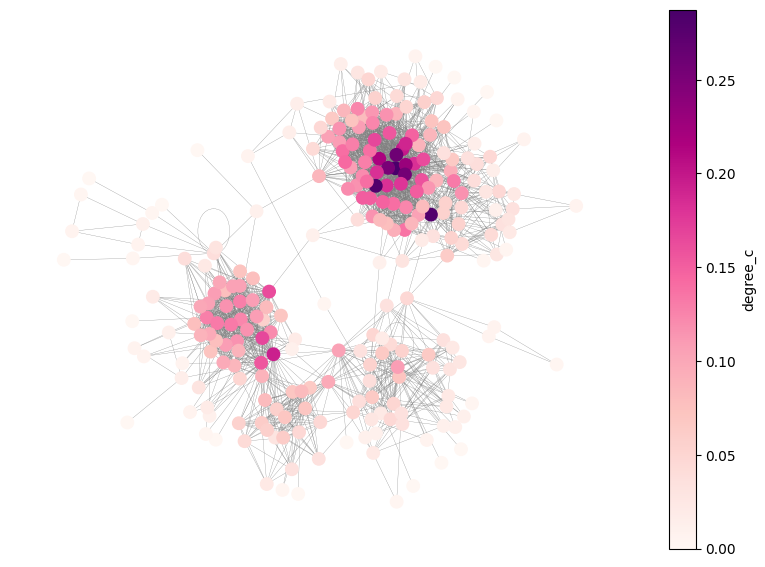

In [87]:
centrality_plots(deg_cs, 'degree_c', g)

Focused on global paths, including between clusters

                name    city  university  closeness_c
231  Георгий Бондарь          НИТУ МИСИС     0.391304
169   Максим Кирякин  Москва         МГУ     0.386095
91    Алиса Семенова  Москва  НИТУ МИСИС     0.383260
101  Дарья Курмукова  Москва                 0.381022
79    Адиля Зухурова  Москва  НИТУ МИСИС     0.364525


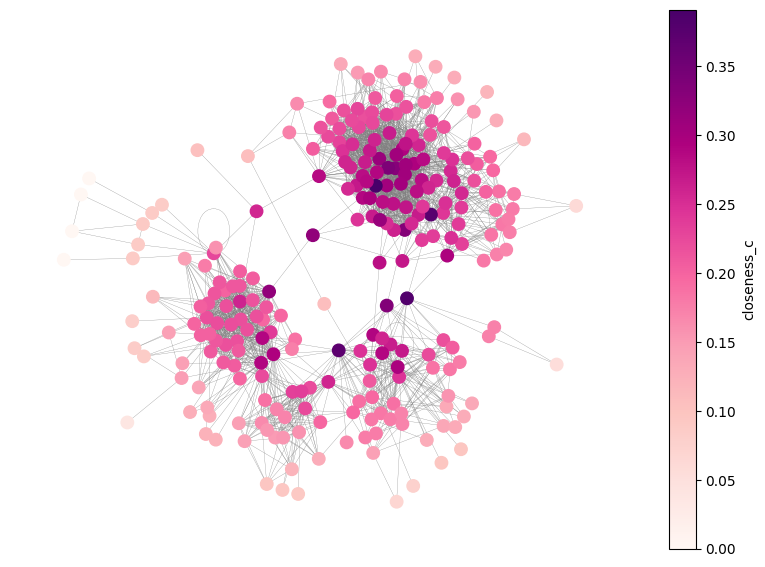

In [90]:
centrality_plots(clos_cs, 'closeness_c', g)

Correlated with closeness centrality

                 name    city  university  eigenvector_c
3    Галина Крынецкая  Москва   НИЯУ МИФИ       0.206140
231   Георгий Бондарь          НИТУ МИСИС       0.199104
81      Даниил Волков  Москва  НИТУ МИСИС       0.193650
129    Арсений Иванов  Москва  НИТУ МИСИС       0.188201
79     Адиля Зухурова  Москва  НИТУ МИСИС       0.184187


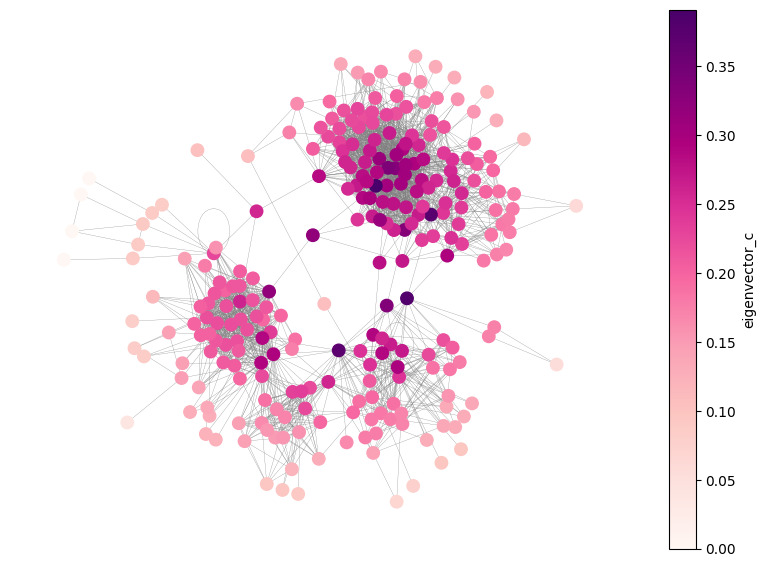

In [91]:
centrality_plots(clos_cs, 'eigenvector_c', g)

## PageRank

PageRank - Measures a node's importance based on the importance of its neighbours; higher scores are given to nodes connected to other highly-ranked nodes.

                   name    city  university  PageRank
91       Алиса Семенова  Москва  НИТУ МИСИС  0.010484
81        Даниил Волков  Москва  НИТУ МИСИС  0.008947
249  Александра Ерохина                      0.008486
3      Галина Крынецкая  Москва   НИЯУ МИФИ  0.008120
221     Алёна Мухортова  Москва   НИЯУ МИФИ  0.008036


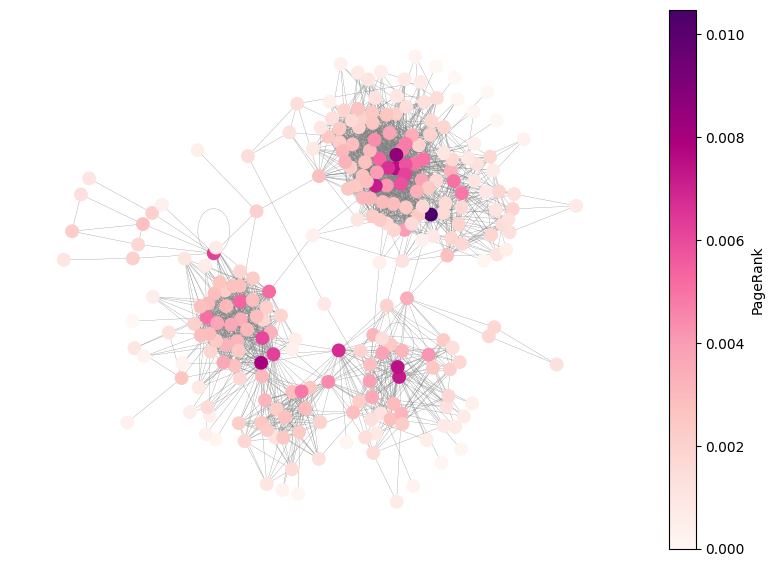

In [92]:
pr_dict = nx.pagerank(g, 0.5)
centrality_df['PageRank'] = pr_dict.values()
centrality_plots(pr_dict, 'PageRank', g)

## Comparison with centralities

In [93]:
def pearson(a,b):
    return np.corrcoef(a, b)[0][1]
def spearman(a,b):
    return spearmanr(a, b)[0]

In [94]:
corrvals = [
    ('Degree centrality', list(centrality_df['degree_c'])),
    ('Closeness centrality', list(centrality_df['closeness_c'])),
    ('Betweenness centrality', list(centrality_df['betweenness_c'])),
    ('Eigenvector centrality', list(centrality_df['eigenvector_c'])),
    ('PageRank', list(centrality_df['PageRank']))
]

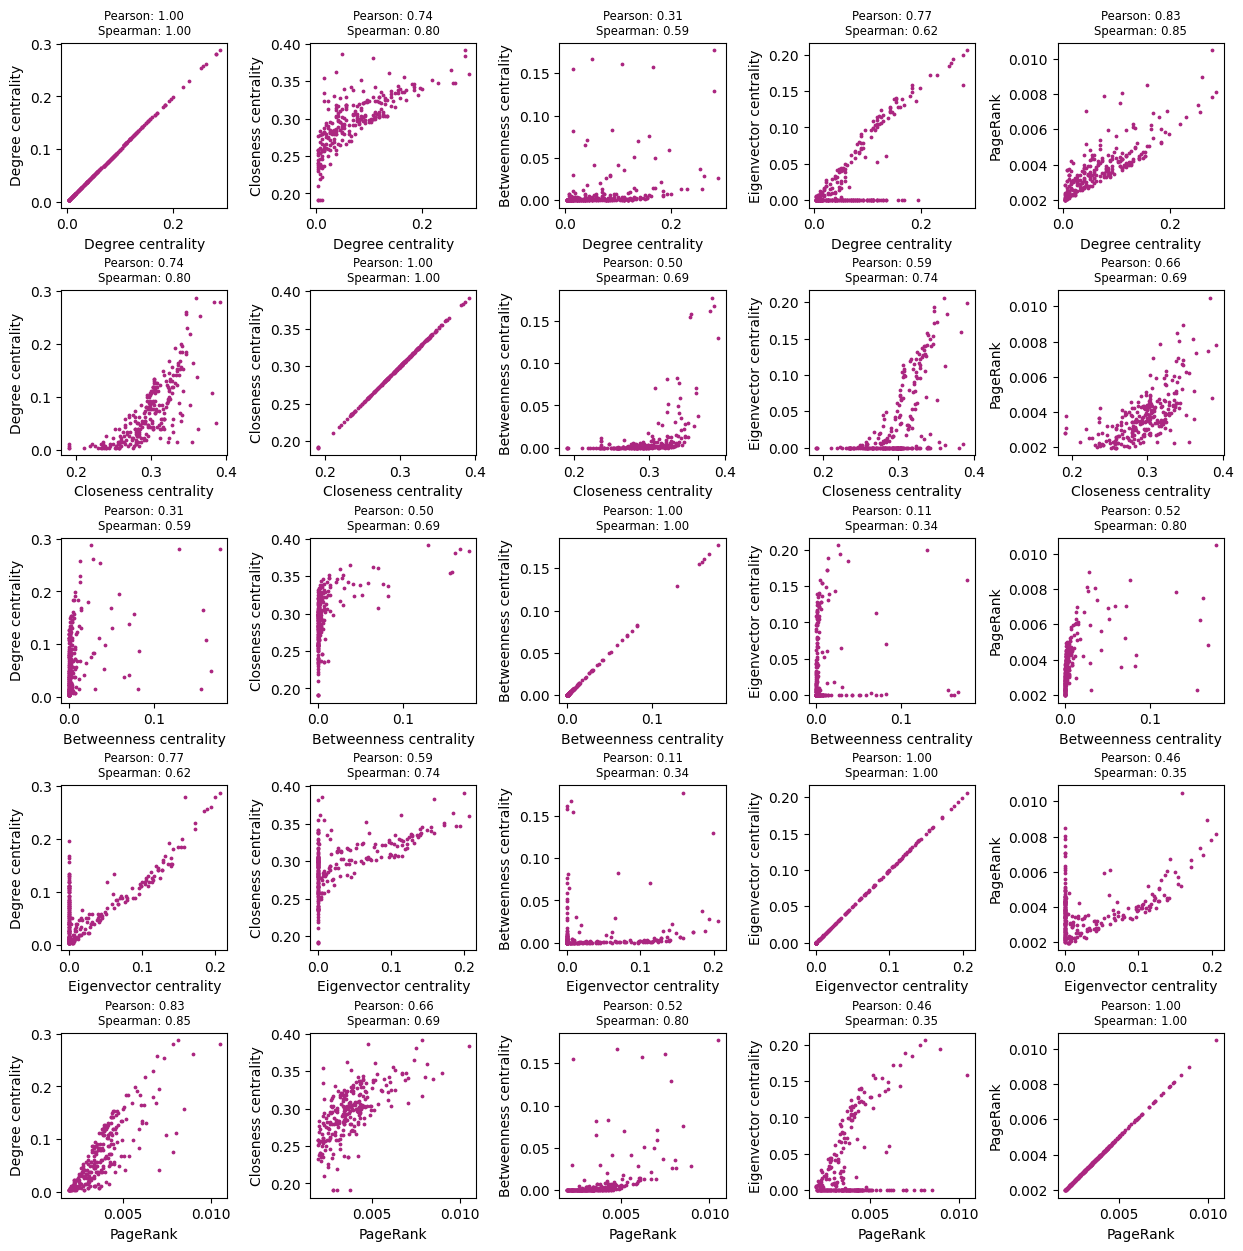

In [95]:
plt.figure(figsize=(5*3, 5*3))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
k = 1
for i in range(len(corrvals)):
    for j in range(len(corrvals)):
        i_label, i_vals = corrvals[i]
        j_label, j_vals = corrvals[j]
        pcorrelation = pearson(i_vals, j_vals)
        scorrelation = spearman(i_vals, j_vals)
        plt.subplot(5, 5, k)
        plt.scatter(i_vals, j_vals, s=3, color=[0.67, 0.15, 0.5, 1])
        plt.title('Pearson: {:.2f}\nSpearman: {:.2f}'.format(pcorrelation, scorrelation), fontsize='small')
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

The scatterplot matrix compares **Degree Centrality**, **Closeness Centrality**, **Betweenness Centrality**, **Eigenvector Centrality**, and **PageRank** using Pearson and Spearman correlation coefficients.

Key Insights
- **Degree, PageRank, and Eigenvector Centrality**:
  - These metrics are highly correlated, focusing on connectivity and influence within dense clusters.
- **Closeness Centrality**:
  - Measures global reachability and has weaker correlations with influence-based metrics.
- **Betweenness Centrality**:
  - Captures the role of bridging communities, making it less correlated with other metrics that focus on connectivity or influence.

### Conclusion
The metrics highlight different aspects of node importance:
- **Degree/PageRank/Eigenvector**: Nodes with many or influential neighbours.
- **Closeness**: Nodes with efficient global reach.
- **Betweenness**: Nodes crucial for interconnecting communities.  

A combined analysis of these metrics provides a comprehensive view of network roles and dynamics.

### Here’s a long summary if you are interested:


**1. Degree Centrality**
- Correlation with Closeness Centrality:
  - Pearson: 0.74, Spearman: 0.80: Strong correlation indicates that nodes with more direct connections tend to be closer to other nodes in the graph. However, outliers suggest that some highly connected nodes may not always minimise path lengths globally.
- Correlation with Betweenness Centrality:
  - Pearson: 0.31, Spearman: 0.59: Moderate correlation implies that highly connected nodes are sometimes critical for bridging paths, but this is not always the case (e.g., hubs in dense clusters).
- Correlation with PageRank and Eigenvector Centrality:
  - PageRank (Pearson: 0.83): High correlation, as both metrics favour highly connected nodes.
  - Eigenvector (Pearson: 0.77): Similar trend due to shared emphasis on connectivity.


**2. Closeness Centrality**
- Correlation with Degree Centrality:
  - Strong correlation (Pearson: 0.74) suggests that nodes with more connections are often closer to others on average.
- Weak correlation with Betweenness:
  - Pearson: 0.11: Indicates that being close to many nodes does not necessarily mean a node acts as a bridge.
- Moderate correlation with PageRank and Eigenvector Centrality:
  - Pearson: 0.52, 0.59: Highlights that Closeness captures global reachability, while the others focus more on influence and local importance.

**3. Betweenness Centrality**
- Low correlation with other metrics:
  - Degree Centrality (Pearson: 0.31) and Closeness (Pearson: 0.11) show limited overlap, as Betweenness emphasises nodes that bridge communities rather than those with high connectivity or proximity.
  - Eigenvector and PageRank correlations (Pearson: ~0.5) suggest that influential nodes sometimes act as bridges, but this is not consistent across the graph.

**4. Eigenvector Centrality**
- High correlation with Degree Centrality:
  - Pearson: 0.77: Eigenvector Centrality strongly favours nodes connected to influential neighbours, so hubs often rank high.
- Moderate correlation with Closeness:
  - Pearson: 0.59:
  - Reflects overlapping but distinct interpretations of influence within the network.

**5. PageRank**
- High correlation with Degree:
  - Pearson: 0.83: PageRank gives higher importance to well-connected nodes, especially those linked to other important nodes, aligning with Degree Centrality.
- Moderate correlation with Closeness:
  - Pearson: 0.52: Suggests that globally well-positioned nodes (in terms of path length) often score well in PageRank.
- Moderate correlation with Eigenvector Centrality:
  - Pearson: 0.66: Captures their shared emphasis on network influence.


## Assortative Mixing

In [96]:
def atr_mapping(G, atr, threshold=2, only_names=True):
  mapping = {}
  atrs = nx.get_node_attributes(G, atr)
  occ_atr = [(v,occ) for v,occ in Counter(atrs.values()).most_common() if v != ''][:threshold]
  for (atr_val, occ), i in zip(occ_atr, range(0,len(occ_atr))):
    mapping[atr_val] = i
  return mapping

def atr_mixing(G, atr, threshold=2):
  mapping_for_plot = atr_mapping(G, atr, threshold)
  mapping_for_func = atr_mapping(G, atr, threshold, only_names=False)
  atrs = nx.get_node_attributes(G, atr)
  mixing = nx.attribute_mixing_matrix(G, atr, mapping=mapping_for_func)

  return mixing, mapping_for_plot

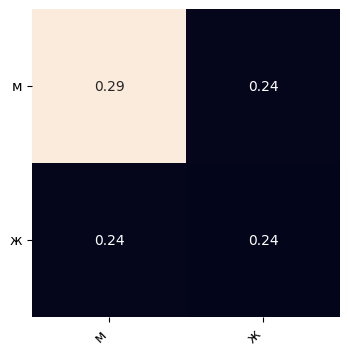

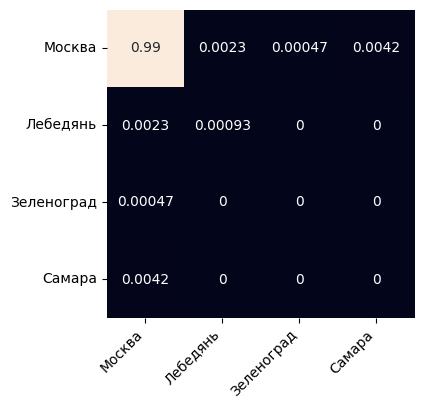

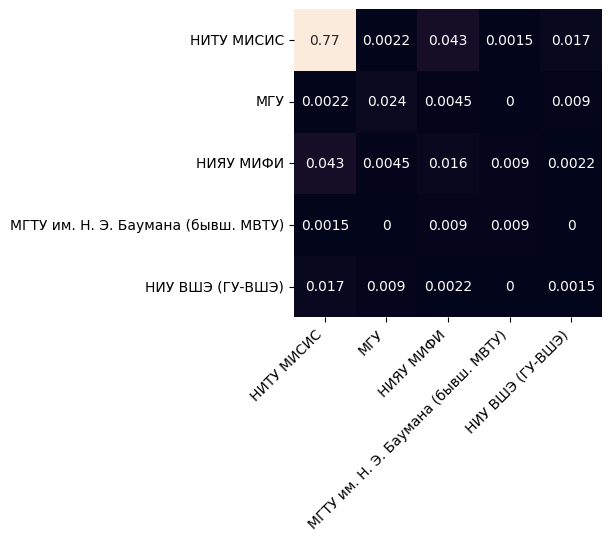

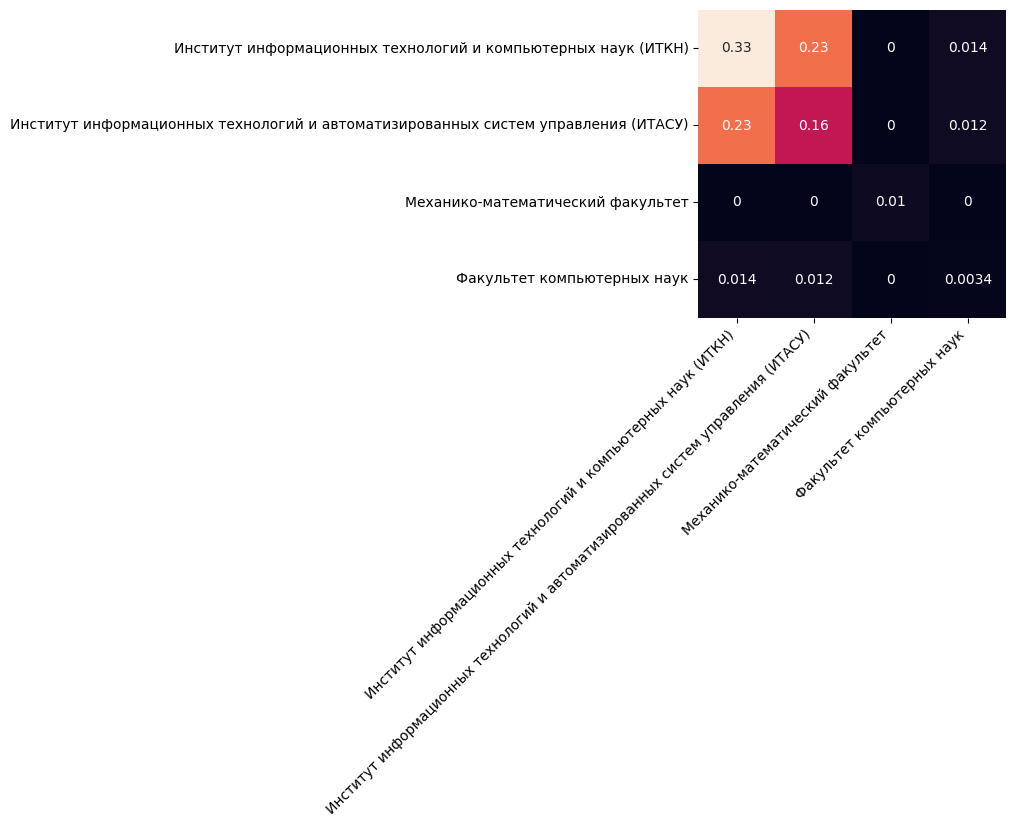

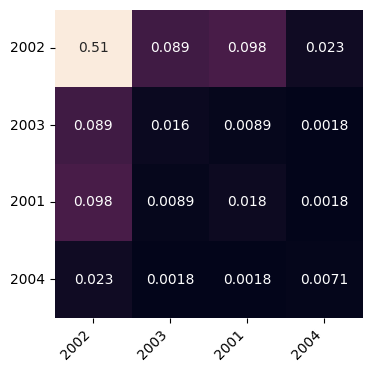

In [97]:
atrs = {'sex':2,
        'city':4, 
        'university_name':5, 
        'faculty_name': 4,
        'byear':4}

for k,v in atrs.items():
  fig = plt.figure(figsize=(4, 4))
  mixing, mapping = atr_mixing(g, k, v)
  hmap = sns.heatmap(
      mixing,
      cbar=False,
      annot=True,
      square=True)
  hmap.set_xticklabels(
      labels=[k for k,_ in mapping.items()], 
      rotation=45, 
      horizontalalignment='right')
  hmap.set_yticklabels(
      labels=[k for k,_ in mapping.items()], 
      rotation=0)
  plt.show()

### Key Points for Heatmaps:

**Gender (First Heatmap)**
- Males have a slightly higher clustering among themselves (0.29) compared to females (0.24).
- Mixed-gender connections also have similar clustering values (0.24), showing a balanced social network interaction pattern.

**City (Second Heatmap)**
- Moscow dominates the network with a clustering value of 0.99, reflecting a strong regional concentration of connections.
- Smaller cities like Lebedyan, Zelenograd, and Samara have much lower clustering values, indicating weaker local social ties or fewer users from those locations.

**University (Third Heatmap)**
- NUST MISIS has the strongest internal clustering (0.77), showing a tightly-knit university community.
- Connections between other universities (e.g., MSU, MEPhI, and Bauman) are weaker, with low clustering values ranging from 0.0015 to 0.043.
- There’s some connectivity between MISIS and other universities, but it’s minimal.

**Faculty (Fourth Heatmap)**
- The Institute of Information Technology and Computer Science (ITCS) shows the highest internal clustering (0.33), followed by ITACS (0.23), indicating strong collaboration within these faculties.
- Other faculties, like the Mechanics and Mathematics Faculty, show very weak clustering, reflecting either fewer members or less interaction.

**Birth Year (Fifth Heatmap)**
- The year 2002 shows the highest clustering (0.51), indicating a strong network among people born in this year.
- Other years (2001, 2003, 2004) show much lower clustering values, with slightly more connections between adjacent years (e.g., 2002–2003 at 0.089).

These insights reveal key patterns in the network and provide a meaningful reflection of my social connections, offering a glimpse into the overall characteristics of my friend group.

## Equivalence

In [99]:
def sim_matrices(G):
  A = nx.to_numpy_array(G)
  pc = np.corrcoef(A)
  J = np.zeros(A.shape)
  for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
    J[i,j] = c 
    J[j,i] = 1-c 

  cs = cosine_similarity(A)
  
  return A, pc, J, cs

def cm_order(G):
  adj_matrix = nx.adjacency_matrix(G)

  return reverse_cuthill_mckee(adj_matrix)

/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alina/miniconda3/envs/jnenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


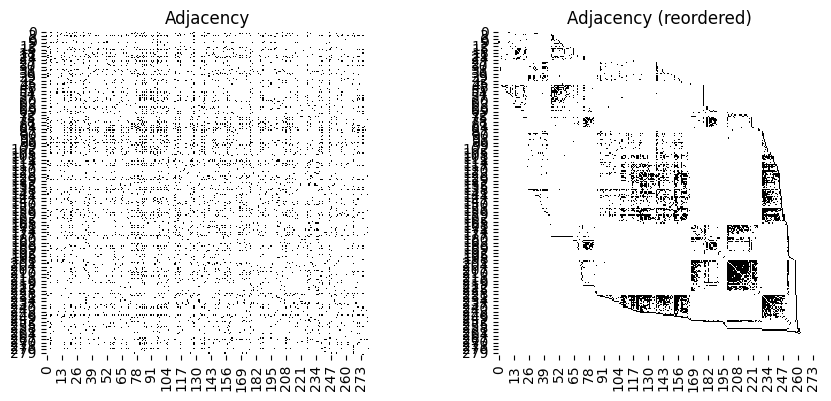

In [100]:
A, corr, J, cos = sim_matrices(G)
order = cm_order(G)

fig = plt.figure(figsize=(10, 10*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(len(nx.degree(G)))],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [1, corr, None, 'Pearson correlation', range(len(nx.degree(G)))], 
         [2, corr, None, 'Pearson correlation (reordered)', order], 
         [1, J, None, 'Jaccard similarity', range(len(nx.degree(G)))], 
         [2, J, None, 'Jaccard similarity (reordered)', order], 
         [1, cos, None, 'Cosine similarity', range(len(nx.degree(G)))], 
         [2, cos, None, 'Cosine similarity (reordered)', order]]

for i, matrix, cmap, t, o in cases[:2]:
    plt.subplot(1, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)
plt.show()

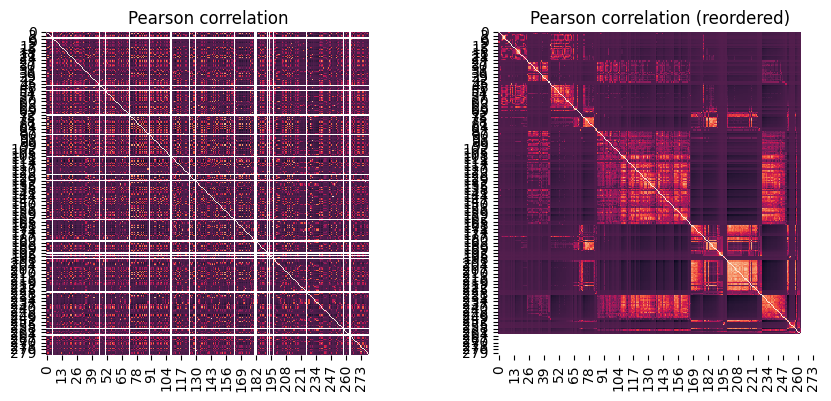

In [101]:
fig = plt.figure(figsize=(10, 10*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, matrix, cmap, t, o in cases[2:4]:
    plt.subplot(1, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)
plt.show()

**The right down corner, I think, my university friends. In the big square we can see small but dense squares. Middle square is, maybe, my school friends.**


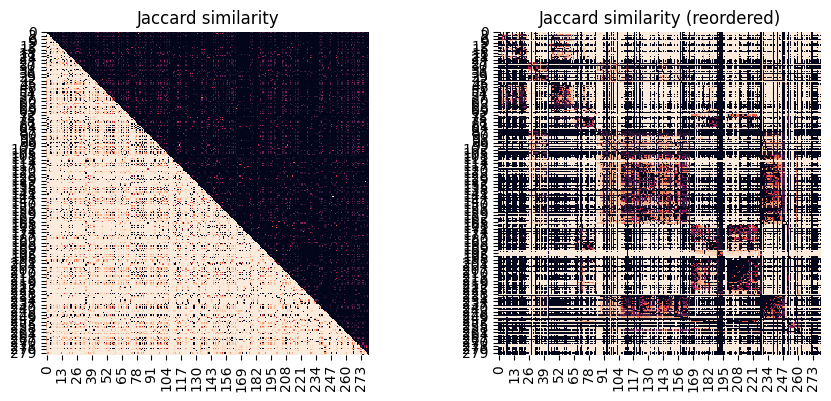

In [97]:
fig = plt.figure(figsize=(10, 10*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, matrix, cmap, t, o in cases[4:6]:
    plt.subplot(1, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)
plt.show()

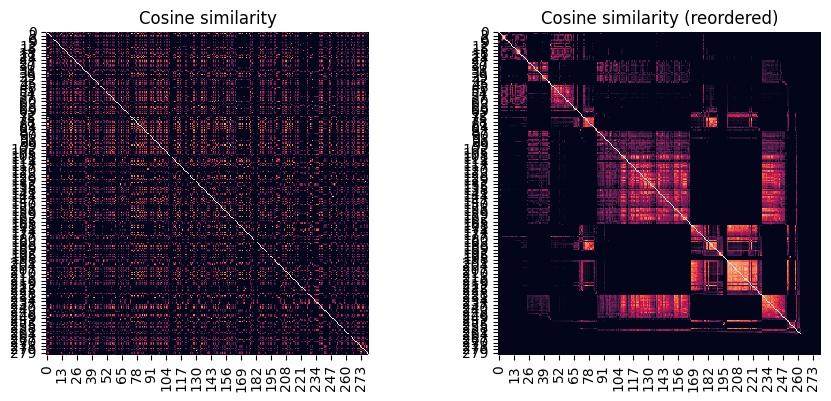

In [98]:
fig = plt.figure(figsize=(10, 10*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, matrix, cmap, t, o in cases[6:8]:
    plt.subplot(1, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)
plt.show()

**As we can see, all similarity matrices have the same pattern.**

## Structural equivalent nodes


In [102]:
node_list = list(G.nodes())
adj_df =pd.DataFrame(A, index=node_list, columns=node_list)

In [103]:
str_eq = [G.index.tolist() for _, G in adj_df.groupby(adj_df.columns.tolist()) if len(G.index) > 1]

In [104]:
for se in str_eq:
  neighbors = [neighbor for neighbor in G.neighbors(se[0])]
  for fr in se:
    print(nx.get_node_attributes(G, 'name')[fr], end=' ')
  print('share', end=' ')
  if not neighbors:
    print('0 friends\n')
  else:
    print(len(neighbors), 'friend {}\n'.format(nx.get_node_attributes(G, 'name')[neighbors[0]]))

Егор Еремин Илья Кузьменко Александр Харукевич Маша Лелюх Сергей Сергеев Николай Дацкевич Павел Стайлов Валентина Николаева Никита Круглов Артём Сухов Айшан Гасанова Аня Бывшева Дарья Антимонова Ангелина Горская Ваня Обрежа Ян Тимофеев Юля Гильмуллина Fedya Mironov share 0 friends

Павел Рощин Максим Владыкин share 1 friend Степан Матвеев

Богдан Савелов Анастасия Никулина share 1 friend Даниил Волков



**There are only structure equivalents in nodes with degree 0. There are just my random friends.**


# Community Detection


## Clique search

A clique in a graph is a subset of nodes where every node is directly connected to every other node (a complete subgraph).

In [102]:
max_clique = sorted(nx.find_cliques(G), key = len, reverse=True)
print('Size of max clique:', len(max_clique[0]))
print('Number of max cliques:', len([c for c in max_clique if len(c)==len(max_clique[0])]))

Size of max clique: 17
Number of max cliques: 19


My network has tightly-knit communities, with multiple large groups where everyone is connected to everyone else:
- The largest fully connected group in your network consists of 17 nodes.
- There are 19 distinct cliques in the graph with the maximum size of 17 nodes.

So, graph have 17 max cliques, let's visualize them

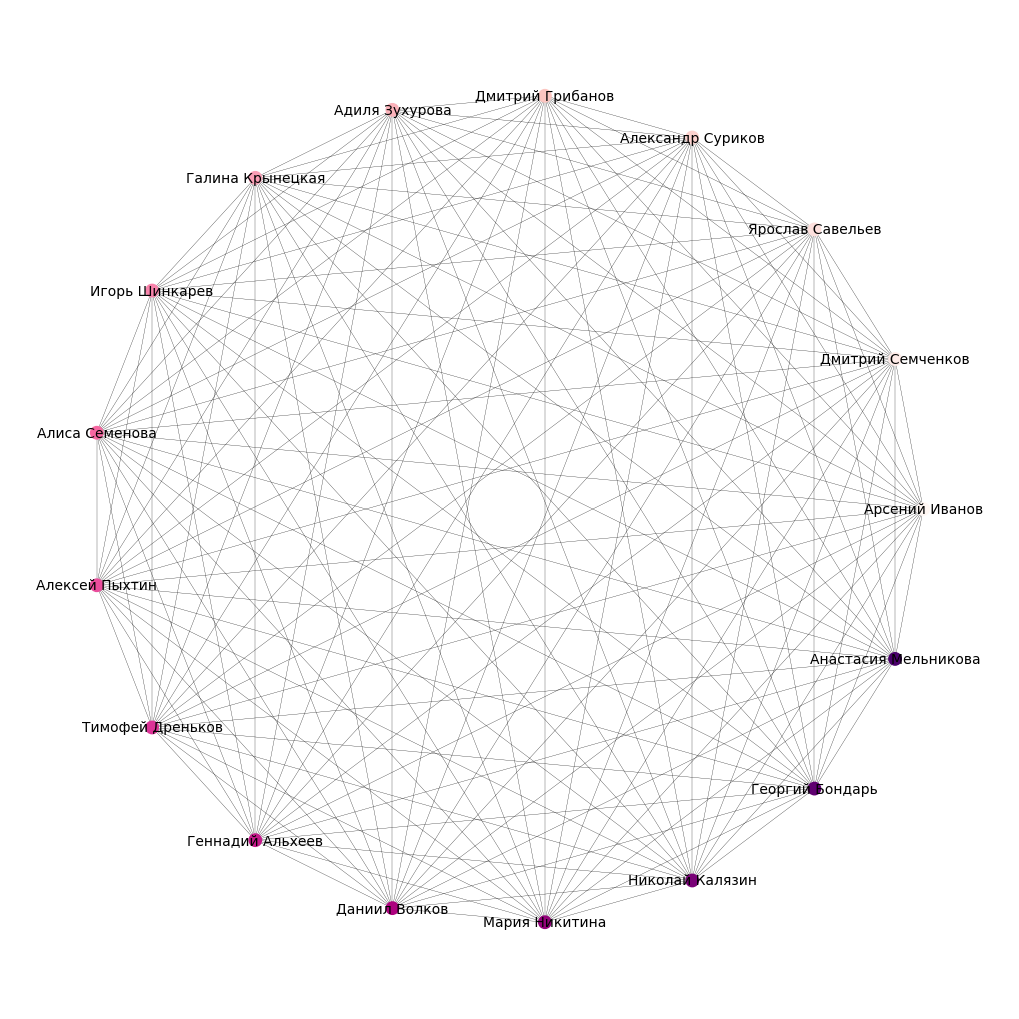

In [106]:
max_c = max_clique[:1]

for k, c in enumerate(max_c):
    plt.figure(figsize=(10, 10))
    c_g = G.subgraph(c).copy()
    names_dict = {}
    for n in c_g:
        names_dict.update({n:c_g.nodes()[n]['name']})
    nx.draw_kamada_kawai(c_g,
                         node_color=range(len(c_g.nodes())),
                         cmap=plt.cm.RdPu,
                         labels=names_dict,
                         font_size=10,
                         node_size=80, 
                         width=0.2)
    plt.show()

This is my university classmates.

## k-core decomposition

Each "core" represents a subset of the graph where nodes are connected with a minimum number of edges. Higher core numbers indicate more densely connected regions of the graph

The connected components that are left after all vertices of degree less than k have been removed are called the k-cores of the graph and the degeneracy of a graph is the largest value k such that it has a k-core.

In [109]:
g = max(nx.connected_components(G), key=len) 
g = G.subgraph(g).copy() 

In [110]:
g.remove_edges_from(nx.selfloop_edges(g))

core_dict = nx.core_number(g)
nx.set_node_attributes(g, {n: {'core': c} for n, c in core_dict.items()})
nx.write_gexf(g, "cores.gexf")

In [114]:
core_dict = nx.core_number(g)
node_colors = [core_dict[n] for n in g.nodes()]
core_counts = Counter(core_dict.values())
total_nodes = len(g.nodes())
core_percentages = {k: (v / total_nodes) * 100 for k, v in core_counts.items()}

print("Core Number Distribution:")
for core, percent in core_percentages.items():
    print(f"Core {core}: {percent:.2f}% of nodes")

Core Number Distribution:
Core 11: 6.84% of nodes
Core 18: 14.45% of nodes
Core 4: 4.56% of nodes
Core 22: 18.25% of nodes
Core 13: 2.28% of nodes
Core 1: 7.22% of nodes
Core 8: 9.51% of nodes
Core 2: 6.08% of nodes
Core 9: 4.18% of nodes
Core 17: 1.52% of nodes
Core 10: 3.04% of nodes
Core 15: 0.76% of nodes
Core 3: 5.70% of nodes
Core 12: 1.14% of nodes
Core 7: 6.08% of nodes
Core 20: 0.76% of nodes
Core 5: 1.90% of nodes
Core 6: 3.04% of nodes
Core 21: 0.76% of nodes
Core 14: 1.52% of nodes
Core 19: 0.38% of nodes


Key Observations:

- Dominant Cores:
    - Core 22 has the largest percentage of nodes (18.25%), indicating that this is the most densely connected region in the graph.
    - Core 18 follows with 14.45%, suggesting another highly connected cluster.
- Lower Core Numbers: 
    - Cores like 1 (7.22%), 2 (6.08%), and 3 (5.70%) represent less connected regions of the graph, with sparse connectivity.
- Rare Cores: 
    - Cores with the smallest percentages (e.g., Core 19, 0.38%) consist of a very small number of nodes that are highly specialised or unique in their connectivity.


The distribution suggests a heterogeneous structure where a few regions are very densely connected (higher cores) while others are more loosely connected (lower cores).

The presence of multiple cores with varying percentages indicates a mix of tightly-knit communities and more peripheral areas in the graph.

Let's visualize the graph with core numbers.

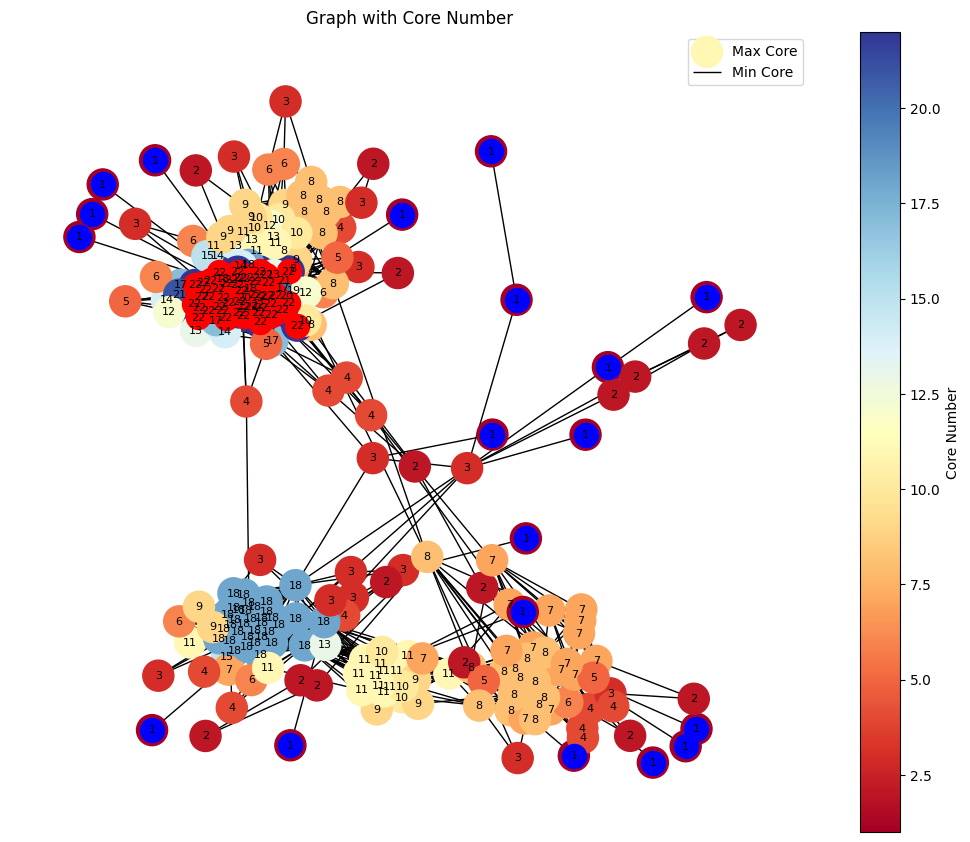

In [115]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(g)

nodes = nx.draw(
    g, pos, node_color=node_colors, cmap=plt.cm.RdYlBu, with_labels=False, node_size=500
)
plt.title("Graph with Core Number")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array(node_colors)
plt.colorbar(sm, ax=plt.gca(), label="Core Number")

for node, (x, y) in pos.items():
    plt.text(
        x, y, str(core_dict[node]),
        fontsize=8, ha="center", va="center", color="black"
    )

max_core = max(core_dict.values())
min_core = min(core_dict.values())
max_nodes = [n for n, c in core_dict.items() if c == max_core]
min_nodes = [n for n, c in core_dict.items() if c == min_core]

nx.draw_networkx_nodes(g, pos, nodelist=max_nodes, node_color="red", label="Max Core")
nx.draw_networkx_nodes(g, pos, nodelist=min_nodes, node_color="blue", label="Min Core")
plt.legend(["Max Core", "Min Core"])

plt.show()

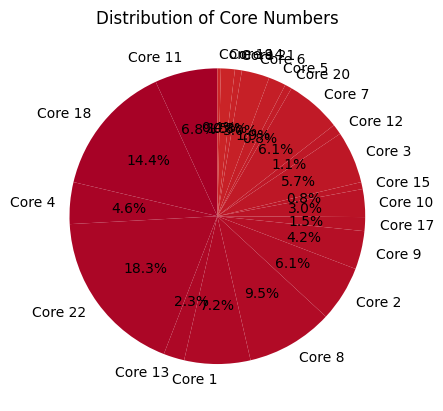

In [116]:
colors = cm.RdYlBu(range(len(core_percentages)))

labels = [f"Core {k}" for k in core_percentages.keys()]
sizes = list(core_percentages.values())

plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
plt.title("Distribution of Core Numbers")
plt.show()

## Community detection

In [138]:
def silhouette_val(graph, partitions):
    """Calculate the silhouette score for graph communities."""
    num_nodes = len(graph.nodes)
    spl_matrix = np.zeros((num_nodes, num_nodes))
    labels = []

    nodes = list(graph.nodes())
    for i, node_a in enumerate(nodes):
        labels.append(partitions[node_a])
        for j, node_b in enumerate(nodes):
            spl_matrix[i, j] = nx.shortest_path_length(graph, node_a, node_b)

    score = silhouette_score(spl_matrix, np.array(labels), metric='precomputed')
    return score


def gmc(graph):
    """Compute communities using the greedy modularity approach."""
    communities = list(com.greedy_modularity_communities(graph))
    partition = {node: idx for idx, community in enumerate(communities) for node in community}
    return communities, partition


def show_communities(algorithm_title, algorithm_func, graph, modularity_scores, silhouette_scores):
    """Visualize graph communities with modularity and silhouette metrics."""
    communities_list, communities = algorithm_func(graph)
    modularity_scores.append(com.quality.modularity(graph, communities_list))
    silhouette_scores.append(silhouette_val(graph, communities))

    pos = nx.spring_layout(graph, seed=42)

    plt.figure(figsize=(12, 8))
    plt.title(f"{algorithm_title}\nModularity: {modularity_scores[-1]:.2f}, Silhouette: {silhouette_scores[-1]:.2f}")

    node_colors = [communities[node] for node in graph.nodes()]
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=100,
        cmap=plt.cm.tab20,
        node_color=node_colors,
        alpha=0.85
    )

    nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color="gray", width=0.5)

    unique_communities = list(set(node_colors))
    plt.legend(
        handles=[plt.Line2D([0], [0], marker='o', color='w', label=f"Community {comm}",
                            markerfacecolor=plt.cm.tab20(comm / len(unique_communities)), markersize=10)
                 for comm in unique_communities],
        title="Communities",
        loc="best"
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()


### Clauset-Newman-Moore greedy modularity maximization

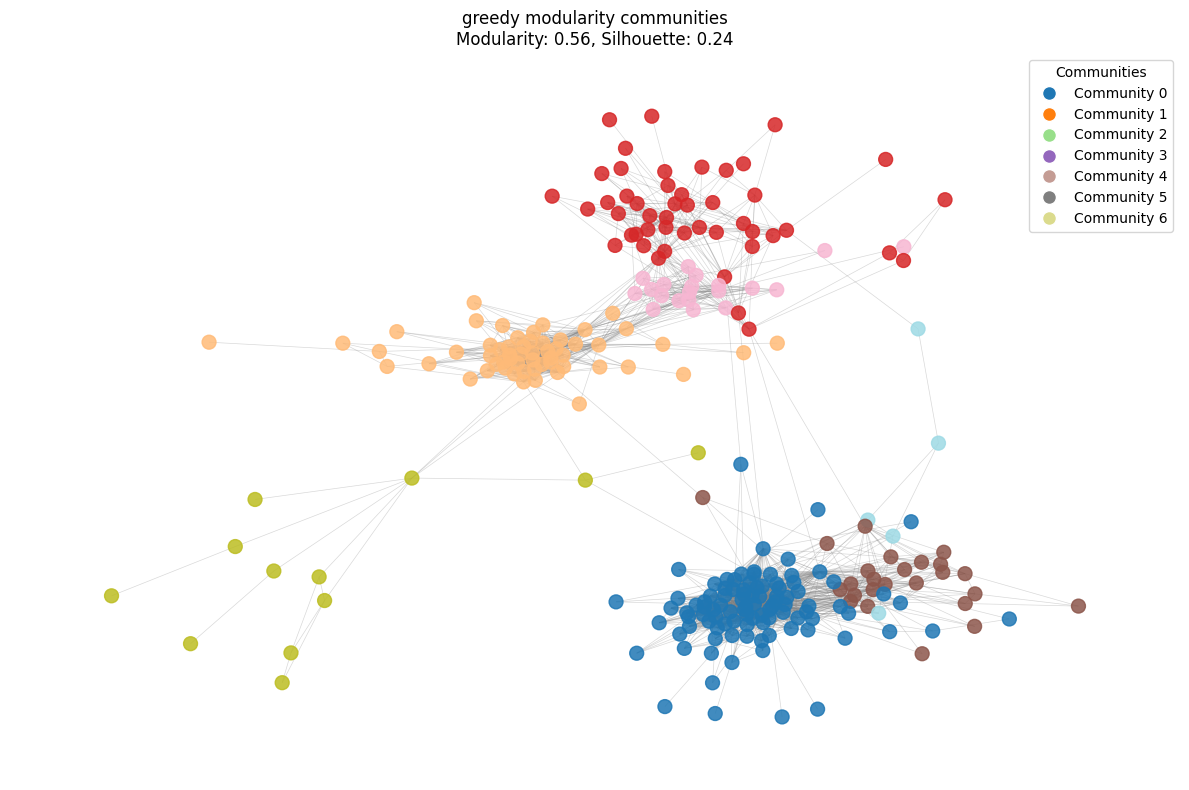

In [140]:
modularity = []
silhouette = []
show_communities('greedy modularity communities', gmc, g, modularity, silhouette)


My Legend for Community Colours

- **Blue**: My university friends  
- **Brown**: My friends partly from university, who were involved in competitive programming  
- **Yellow**: Friends from my second school  
- **Pink**: Friends from my first school  
- **Red**: People I went on hikes with (some of them are from my first school)  
- **Green**: My relatives and childhood friends  

### Louvain method

In [145]:
def lm(graph):
  """Find communities using the Louvain method."""
  partition = community_louvain.best_partition(graph)
  communities = []
  unique_communities = set(partition.values())
  for community_id in unique_communities:
      community_nodes = {node for node, comm_id in partition.items() if comm_id == community_id}
      communities.append(community_nodes)
  return communities, partition

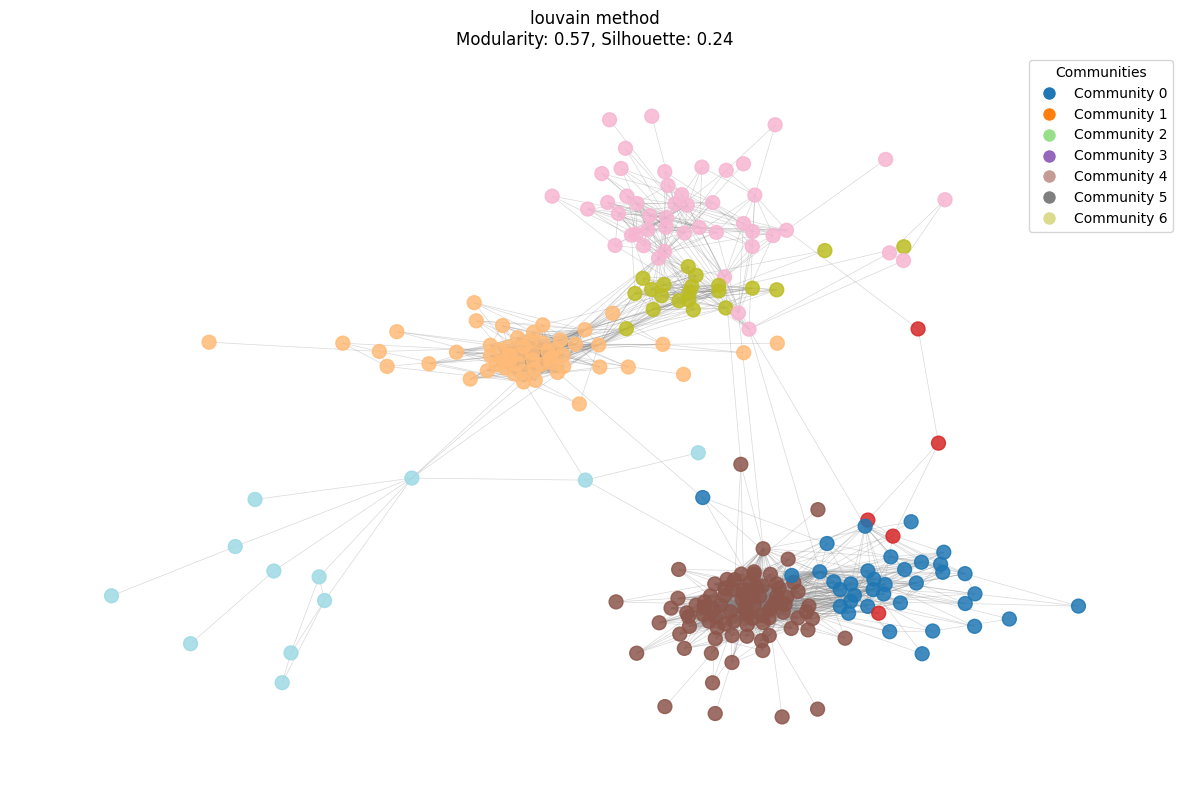

In [146]:
show_communities('louvain method', lm, g, modularity, silhouette)

The same structure as greedy modularity communities.

### Spectral clustering

In [147]:
def norm_laplacian(A):
    G = nx.from_numpy_array(A)
    D = np.array(list(dict(G.degree()).values())).astype(int)
    L = np.diag(D**(-1/2)) @ (np.diag(D) - A) @ np.diag(D**(-1/2))
    return L, D

def spectral_embedding(L, degree_seq, n_components):
    _, vecs = np.linalg.eigh(L)
    return (vecs * degree_seq.reshape((-1, 1))**(-1/2))[:, 1:n_components+1]

def sc(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    partition = dict(zip(G.nodes(), kmeans.labels_))
    unique_com = set(v for _,v in partition.items())
    coms = []
    for com in unique_com:
      com_list = set()
      for k,v in partition.items():
        if v == com:
          com_list.add(k)
      coms.append(com_list)
    return coms, partition

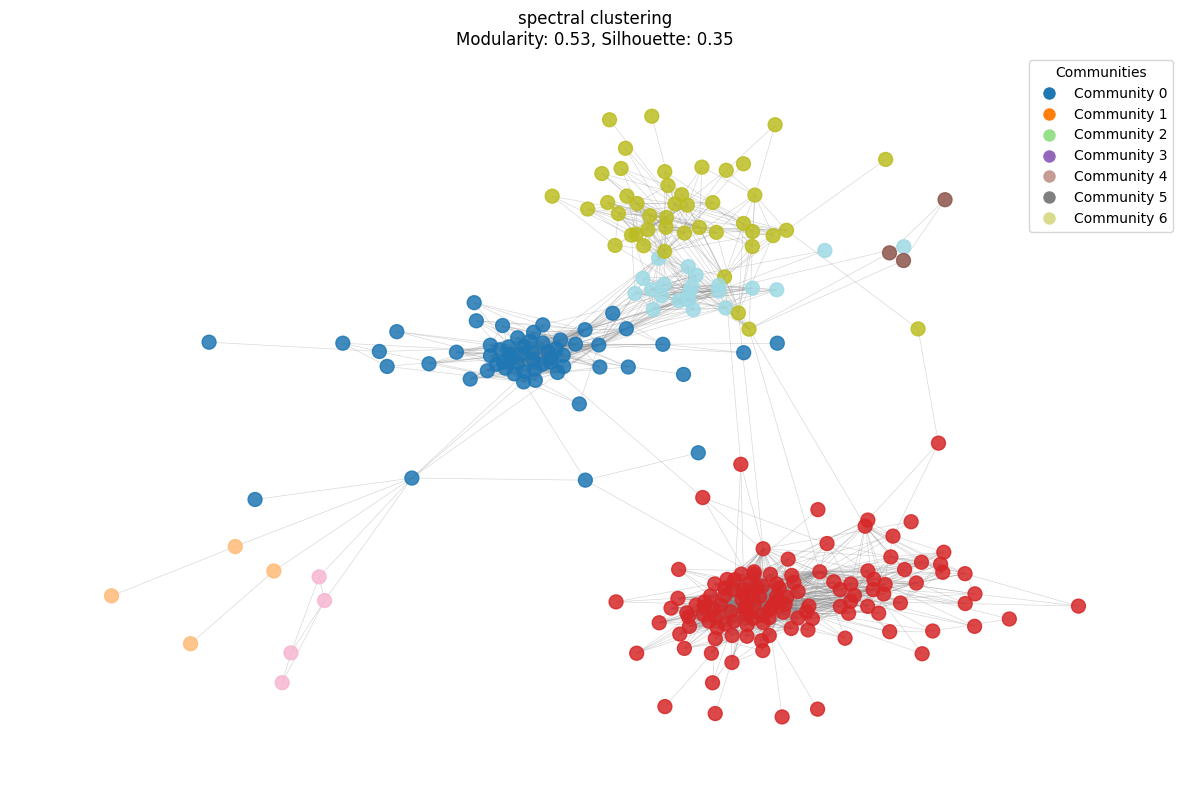

In [148]:
show_communities('spectral clustering', lambda x: sc(x, 7, 6), g, modularity, silhouette)

For now, there are different communities for my relatives and childhood friends. The university friends are in the same community as well. Much better than greedy modularity and louvain method!!!

### Comparising

In [165]:
comm_quality_df = pd.DataFrame(data= {
                              'modularity': modularity,
                              'silhouette': silhouette}, 
                               index = ['greedy modularity communities', 
                                        'louvain method', 
                                        'spectral clustering', 
                                        ])
comm_quality_df['sum'] = comm_quality_df.sum(axis=1)/len(comm_quality_df.columns)

In [166]:
comm_quality_df.sort_values(by=['sum'], ascending=False)

modularity  silhouette       sum
spectral clustering              0.534847    0.352898  0.443873
louvain method                   0.570609    0.241785  0.406197
greedy modularity communities    0.558639    0.236218  0.397429

It aligns with my opinion